# MNIST

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset, DataLoader, ConcatDataset

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

from joblib import Parallel, delayed

from utlis import renormalize_image, vectorize_tensor, reconstruct_tensor
import ld

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Setup

### General

In [2]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    cp.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

load = True

set_random_seed(2)
k = 8
bandwidth = 0.05
bandwidth_AE = 0.05
eps = np.asarray(1.0e-5)
plot_num = 20
paper_plot_num = 1

### Dataset

In [3]:
class NumpyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy.array): Array of shape (N, H, W, C).
            labels (numpy.array): Labels array of shape (N,).
            transform (callable, optional): Transformations to apply to each sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        # Convert (H, W, C) -> (C, H, W) for PyTorch
        # print(img.shape)
        img = torch.tensor(img).reshape(28, 28, 1).permute(2, 0, 1).float() / 255.0

        # Apply transformation if provided
        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
D = 28*28
S = (7, 2, 2, 7, 2, 2)
train_size_per_digit = 5000
test_size = 10000
new_sample_size_per_digit = 1000

# Print dataset statistics
print(f"Train size: {train_size_per_digit * 10}")
print(f"Test size: {test_size}")
print(f"New sample size: {new_sample_size_per_digit * 10}")
print(f"Number of classes: 10")
print(f"Number of features: {D}")

Train size: 50000
Test size: 10000
New sample size: 10000
Number of classes: 10
Number of features: 784


In [5]:
train_dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.1307], std=[0.3081]),]))

save_dir = './data/MNIST_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    # Save images by class
    for class_label in range(10):
        class_dir = os.path.join(save_dir, str(class_label))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        basis = np.where(train_dataset.targets.numpy() == class_label)[0]
        for i, idx in enumerate(basis):
            img, _ = train_dataset[idx]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(class_dir, f'{i}.png'))

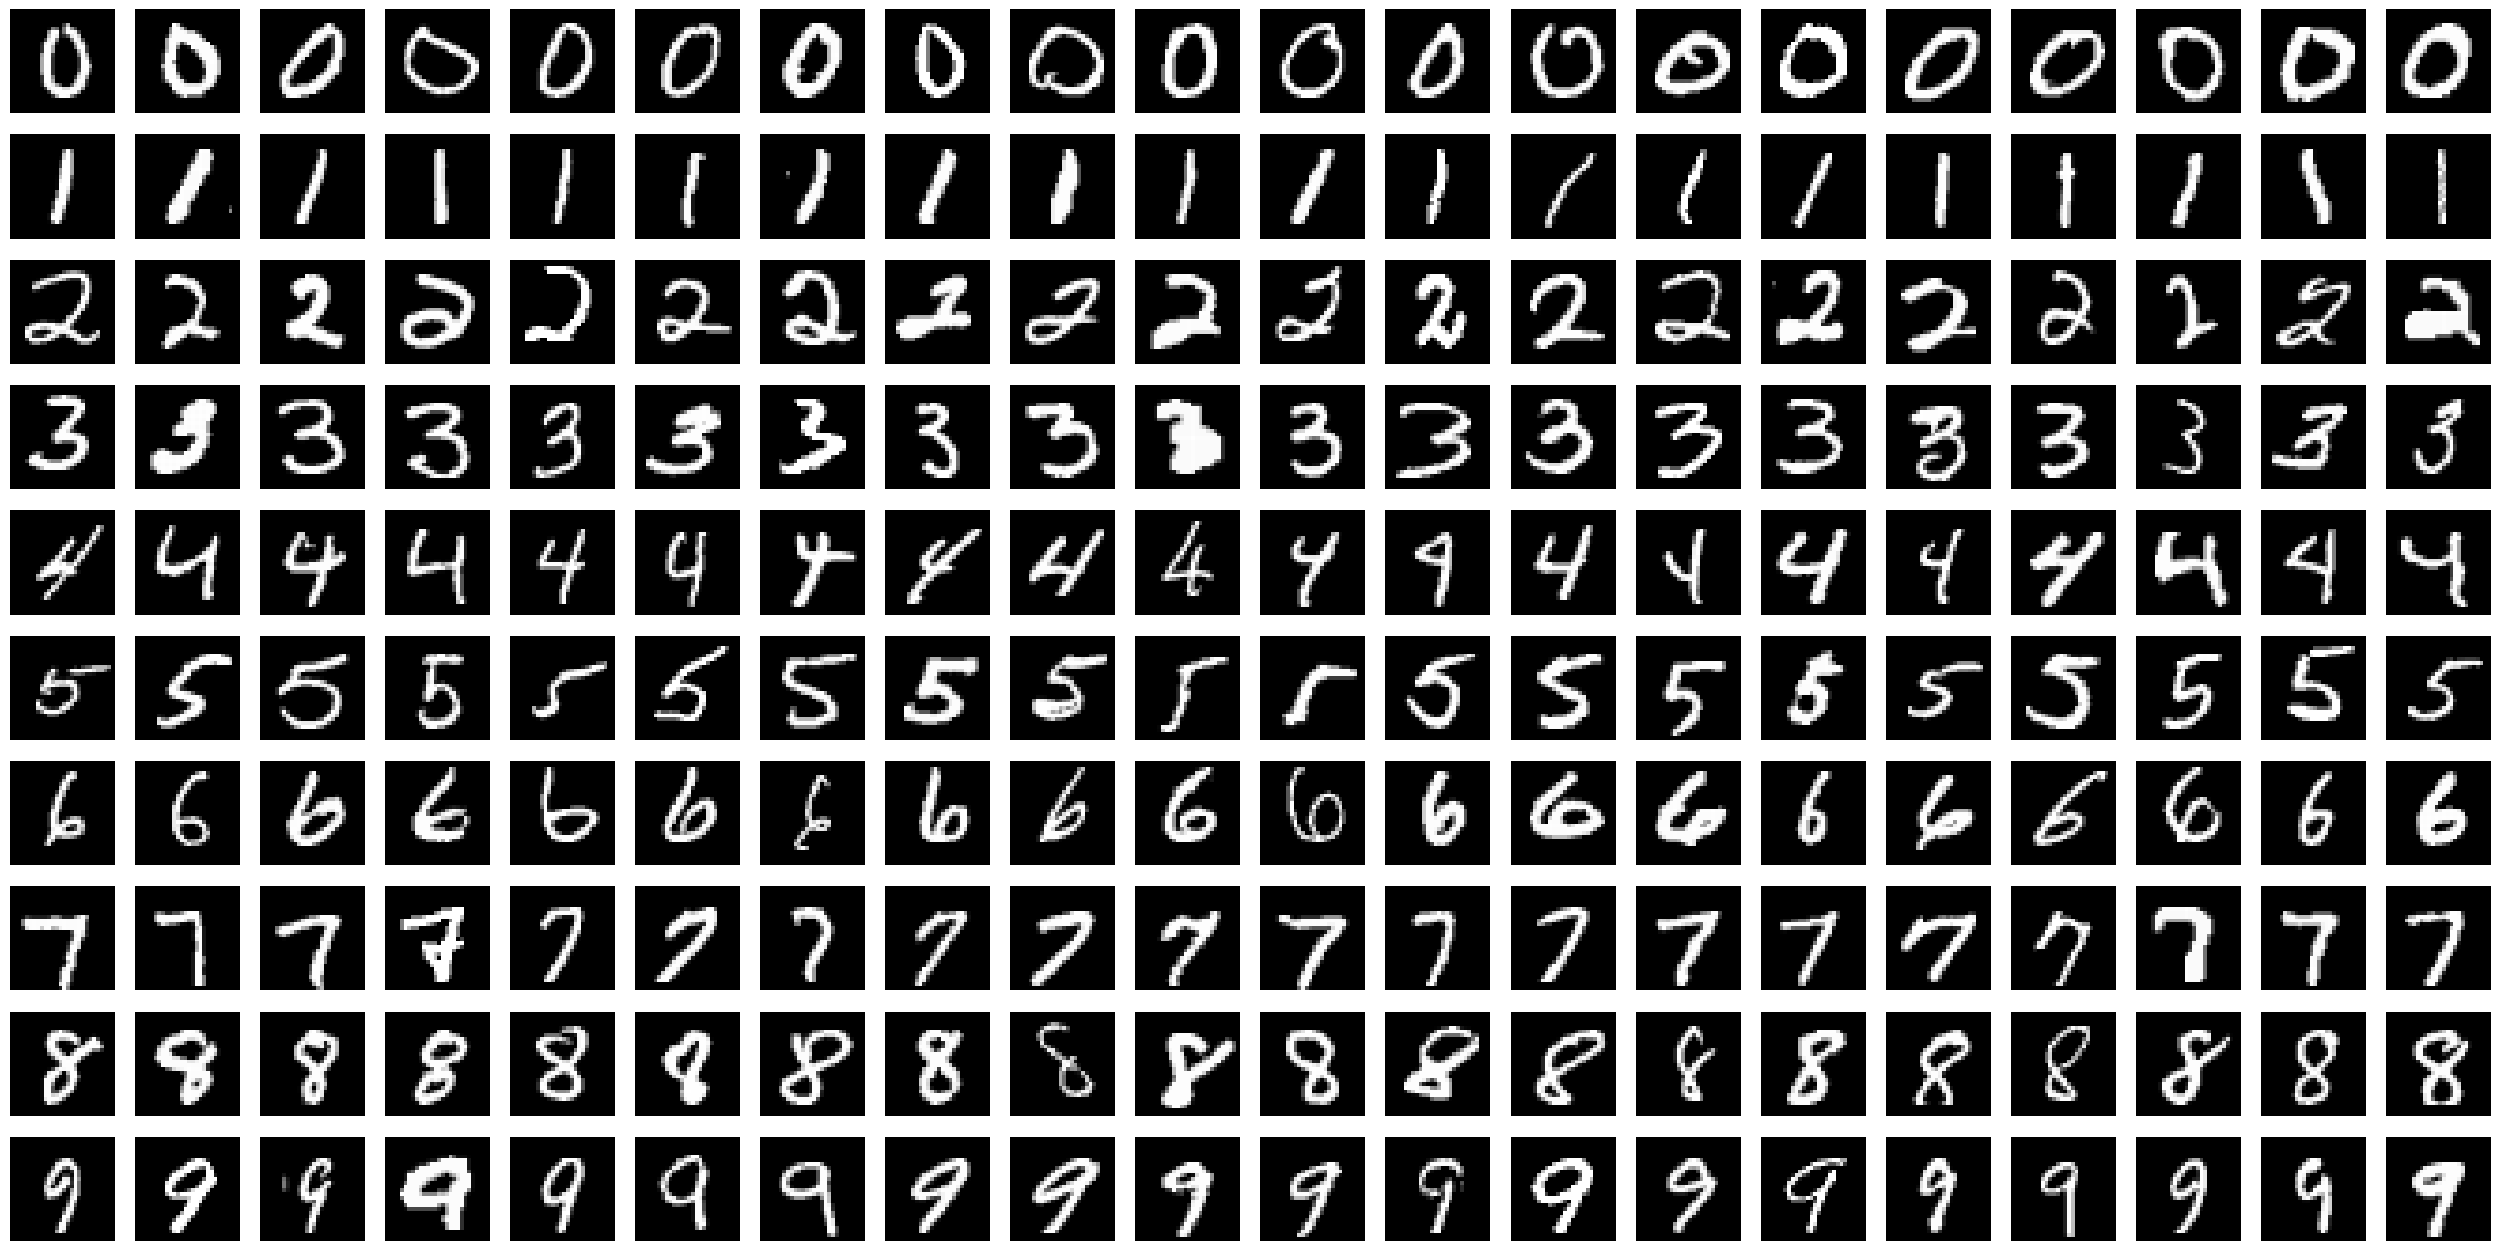

In [6]:
# Function to load images from a directory
def load_images_from_folder(folder, max_images=20):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

P_digit = []
original_data = []

for digit in range(10):
    class_folder = os.path.join(save_dir, str(digit))
    images = load_images_from_folder(class_folder, max_images=train_size_per_digit)

    P = []
    for i in range(len(images)):
        img = images[i]
        img = img.resize((28, 28))
        original_data.append(np.asarray(img))
        array_obj = np.asarray(img).reshape(S)
        P.append(array_obj)

    P_digit.append(np.array(P))

# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][i].reshape((28,28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

## Direct Fitting

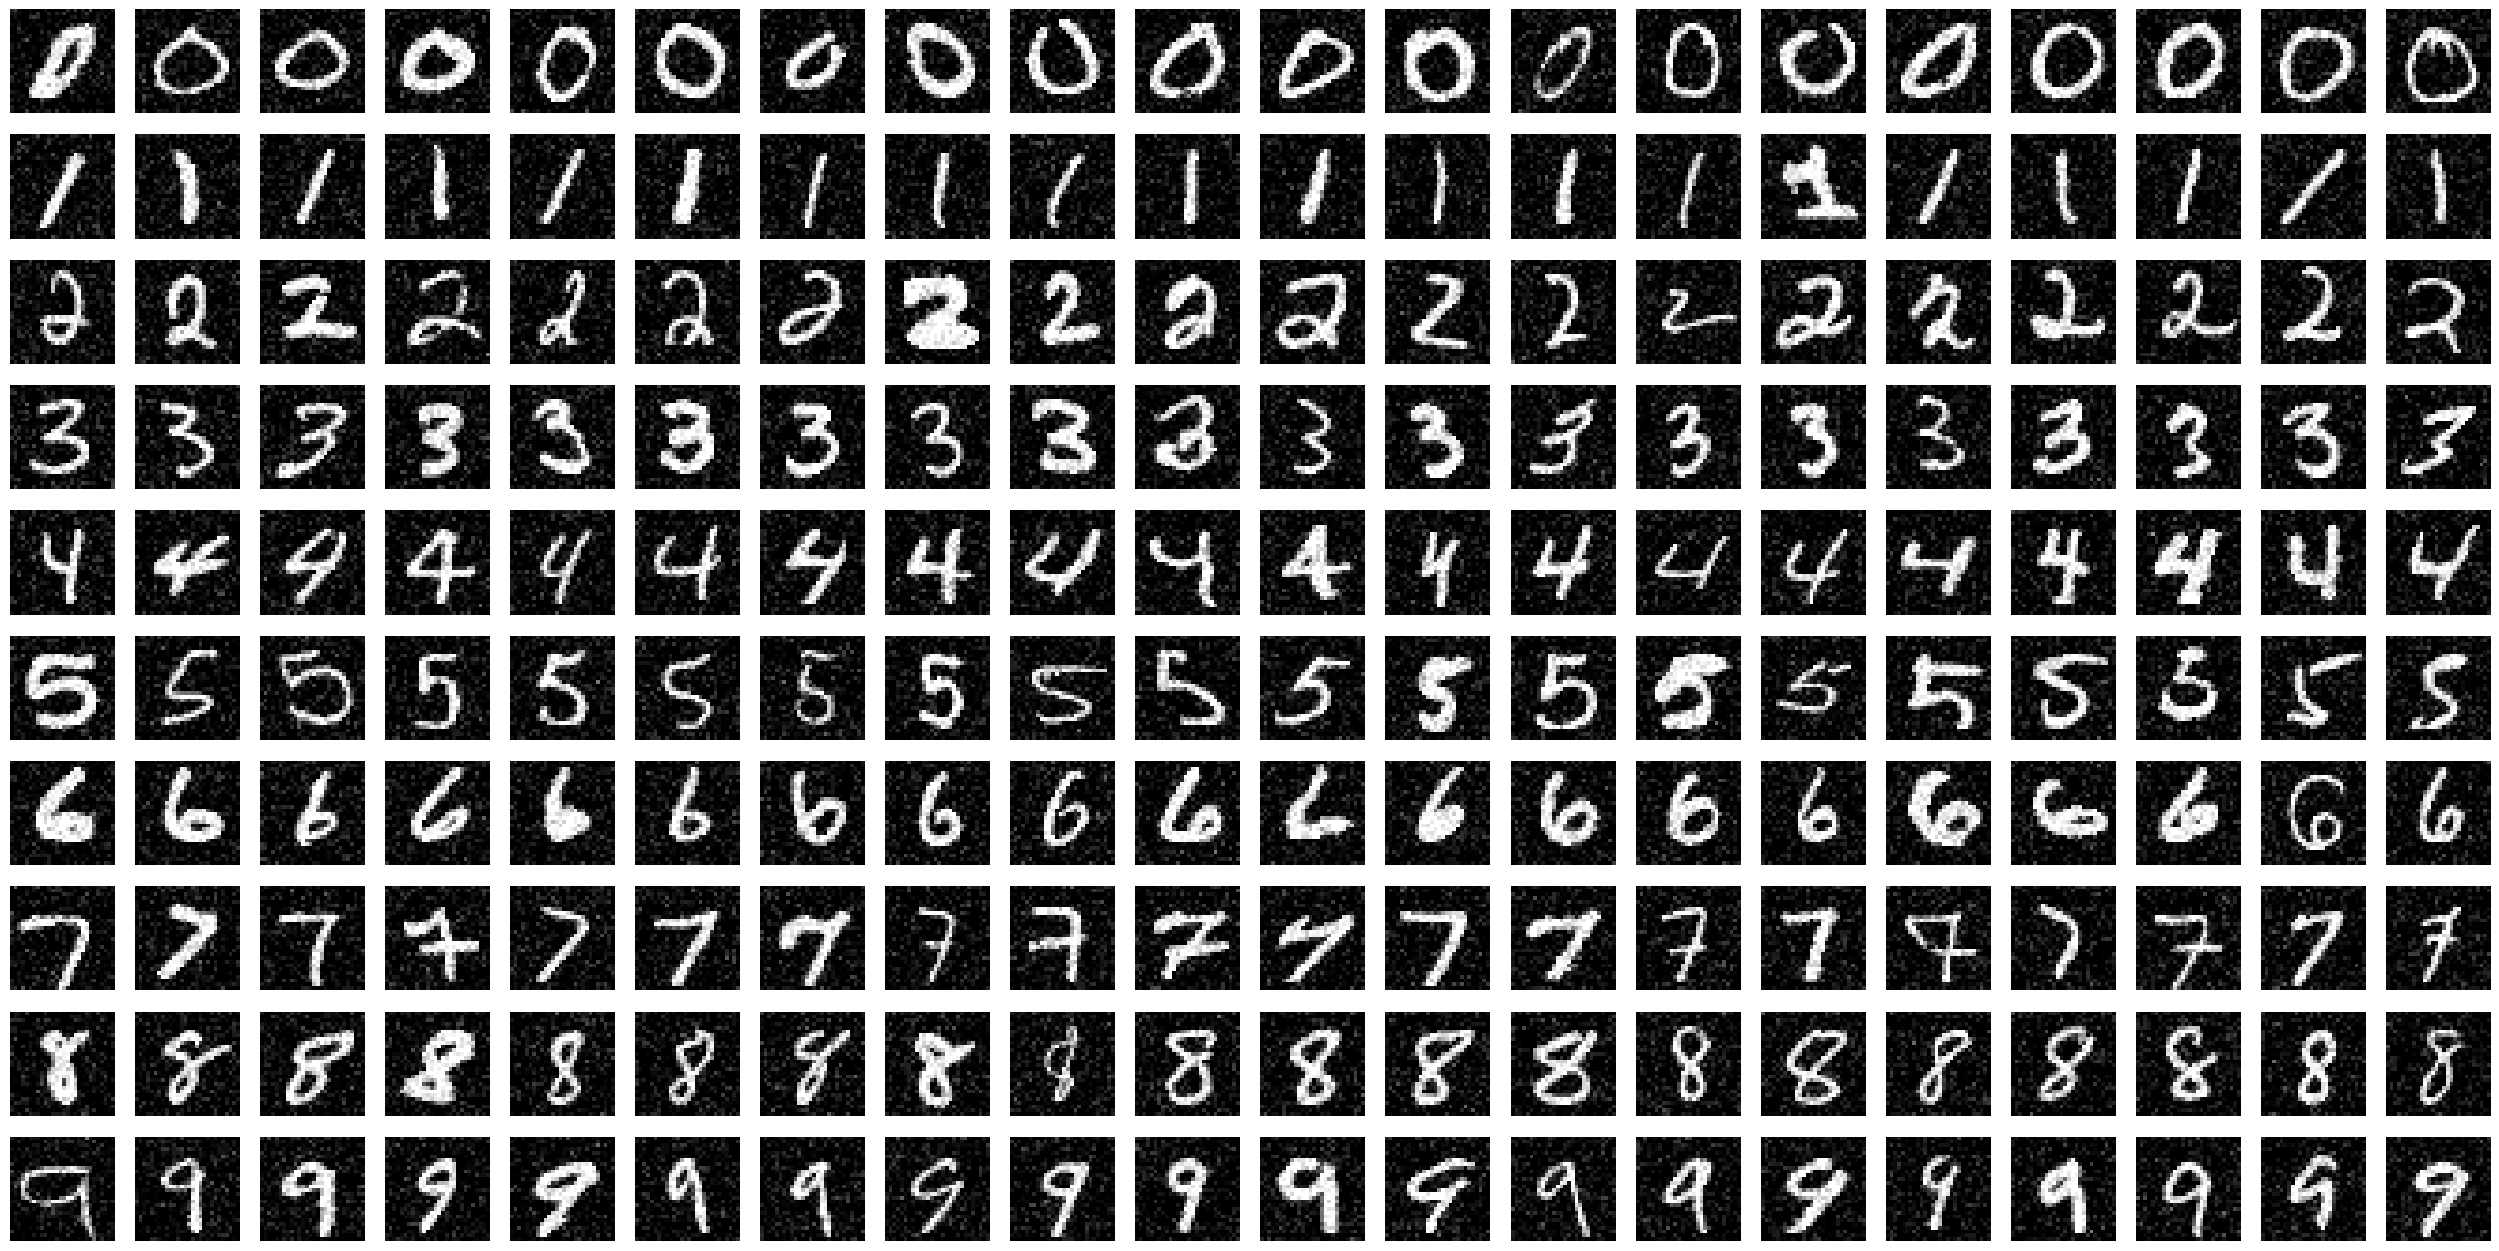

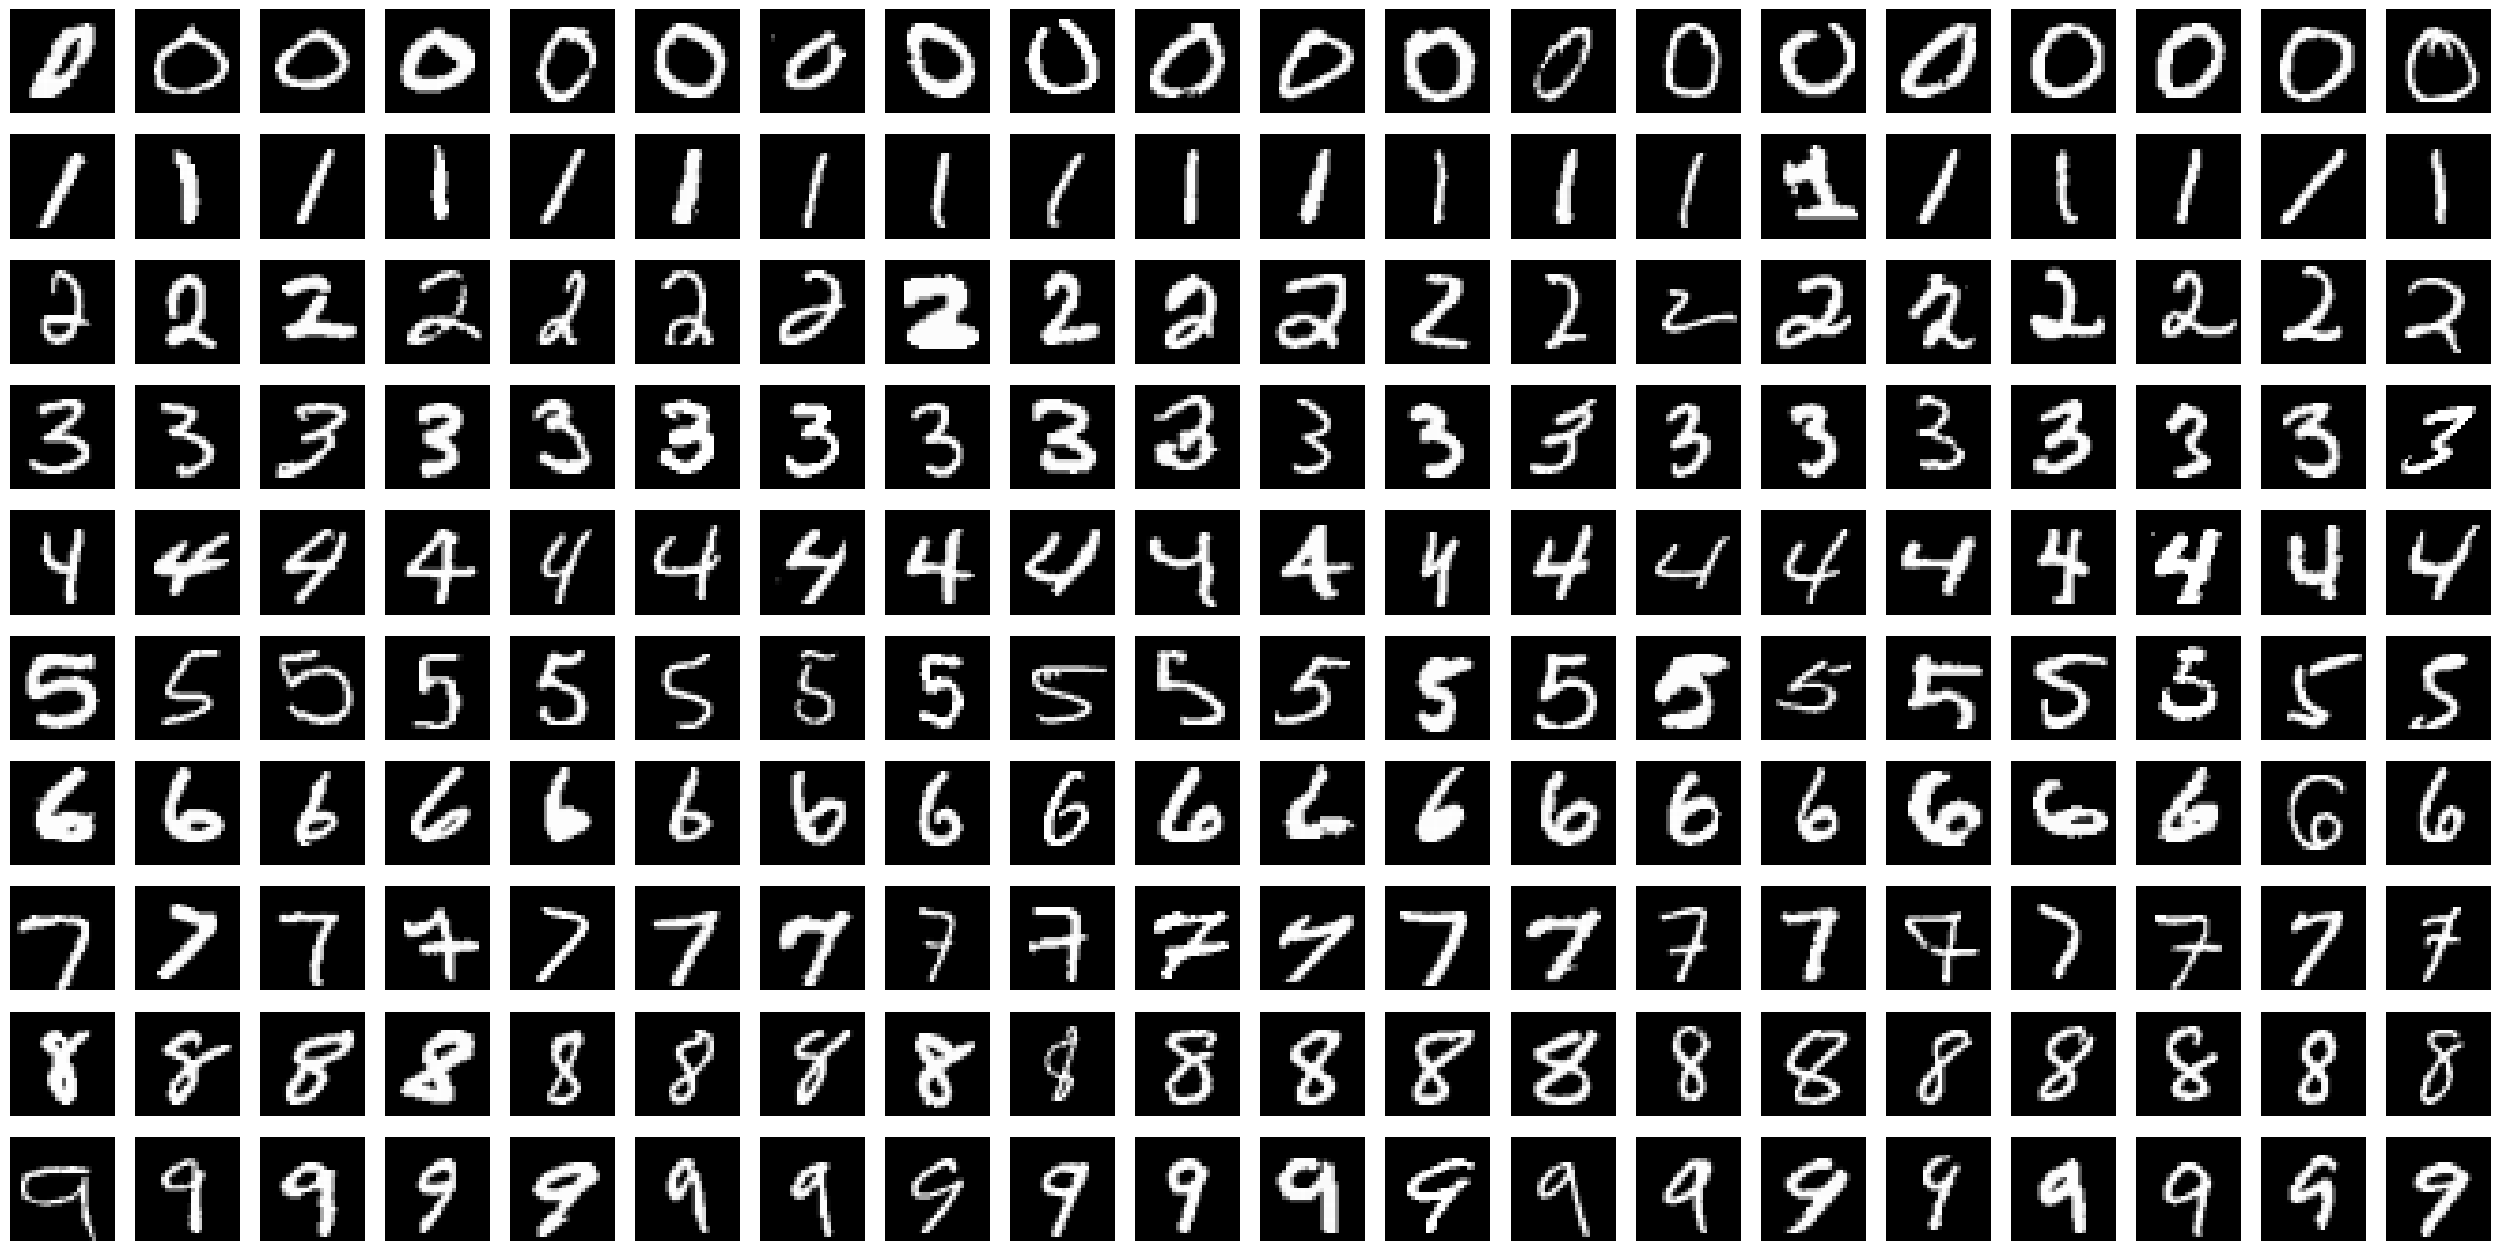

In [7]:
B_LD = ld.default_B(S, len(S), cp.get_array_module(P[0])) # Full Basis (direct fitting essentially)

sampled_P_digit = []

for digit in range(10):
    reduced_P = vectorize_tensor(P_digit[digit], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=30).fit(reduced_P)

    # Sample new data from the KDE
    sampled_reduced_P = kde.sample(n_samples=new_sample_size_per_digit)

    sampled_P = reconstruct_tensor(sampled_reduced_P, (new_sample_size_per_digit, *S), B_LD)
    sampled_P_digit.append(sampled_P)

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(sampled_P_digit[digit][i].reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_P_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

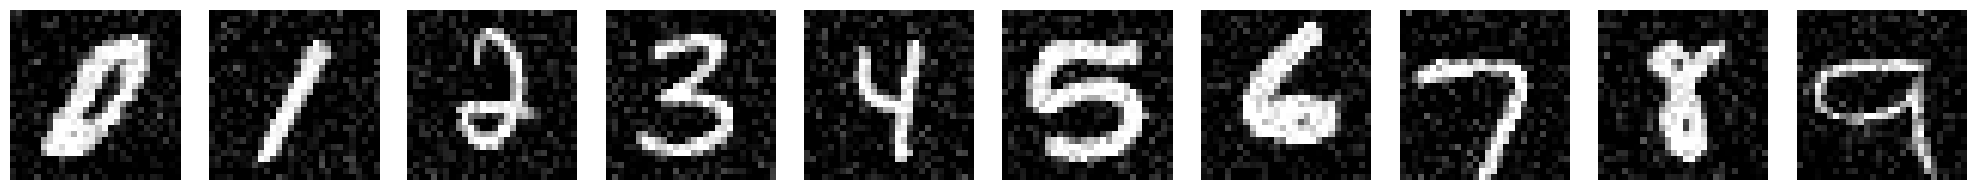

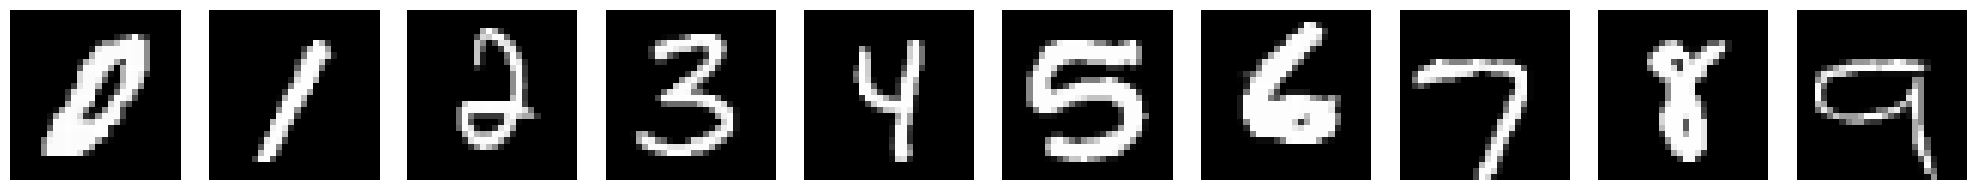

In [8]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(sampled_P_digit[digit][i].reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/direct_fitting.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_P_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/direct_fitting_compare.pdf', format='pdf')

plt.show()

## Pseudo-Non-Linear Data Augmentation

### Legendre Decomposition (Many-Body Approximation)

In [9]:
B_LD = ld.default_B(S, 1, cp.get_array_module(P[0]))
print(f"Dimension of Base Sub-Manifold: {B_LD.shape[0]}")

# Store all intermediate results to disk
if load:
    # Load all intermediate results from disk
    results = np.load('results_LD.npz')
    scaleX_digit = results['scaleX_digit']
    Q_digit = results['Q_digit']
    theta_digit = results['theta_digit']
    X_recons_digit = results['X_recons_digit']
else:
    def LD_helper(i, digit):
        _, _, scaleX, Q, theta = ld.LD(P_digit[digit][i], B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
        return (scaleX, Q, theta)

    results = Parallel(n_jobs=30)(delayed(LD_helper)(i, digit) for i in range(train_size_per_digit) for digit in range(10))

    scaleX_digit = []
    Q_digit = []
    theta_digit = []
    X_recons_digit = []

    for digit in range(10):
        scaleX_list = []
        Q_list = []
        theta_list = []
        X_recons_list = []
        for i in range(train_size_per_digit):
            result = results[i*10 + digit]

            scaleX_list.append(result[0])
            Q_list.append(result[1])
            theta_list.append(result[2])
            X_recons = (result[1] * result[0]).astype(np.int32)
            X_recons_list.append(X_recons)

        scaleX_digit.append(np.array(scaleX_list))
        Q_digit.append(np.array(Q_list))
        theta_digit.append(np.array(theta_list))
        X_recons_digit.append(np.array(X_recons_list))

    np.savez('results_LD.npz', scaleX_digit=scaleX_digit, Q_digit=Q_digit, theta_digit=theta_digit, X_recons_digit=X_recons_digit)

Dimension of Base Sub-Manifold: 17


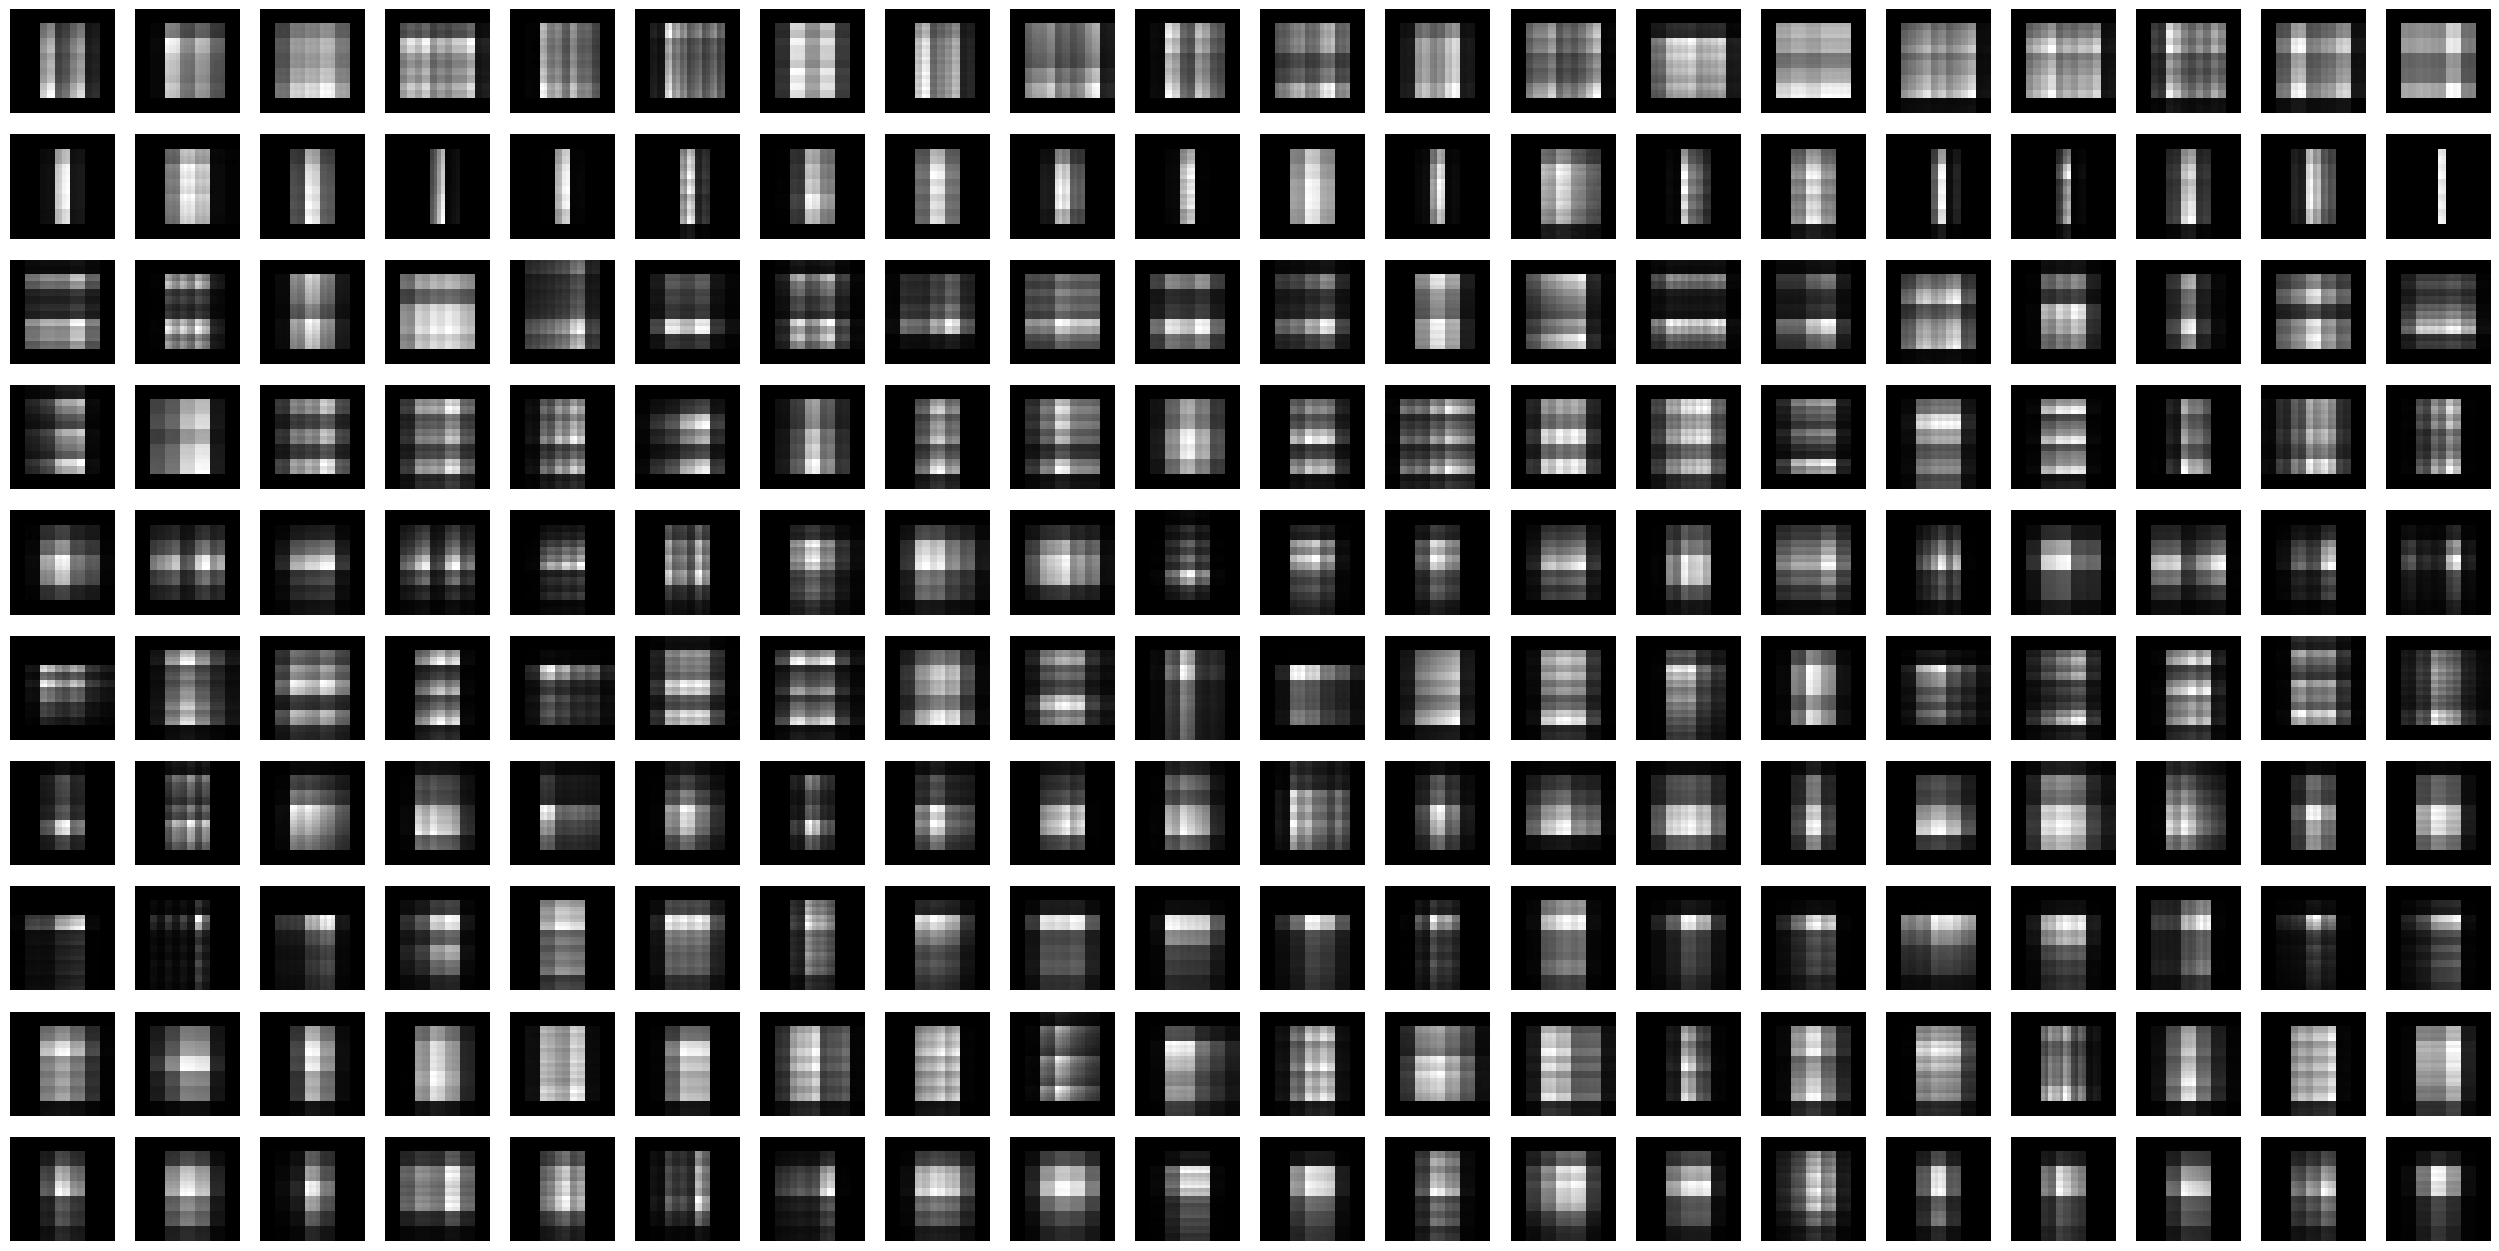

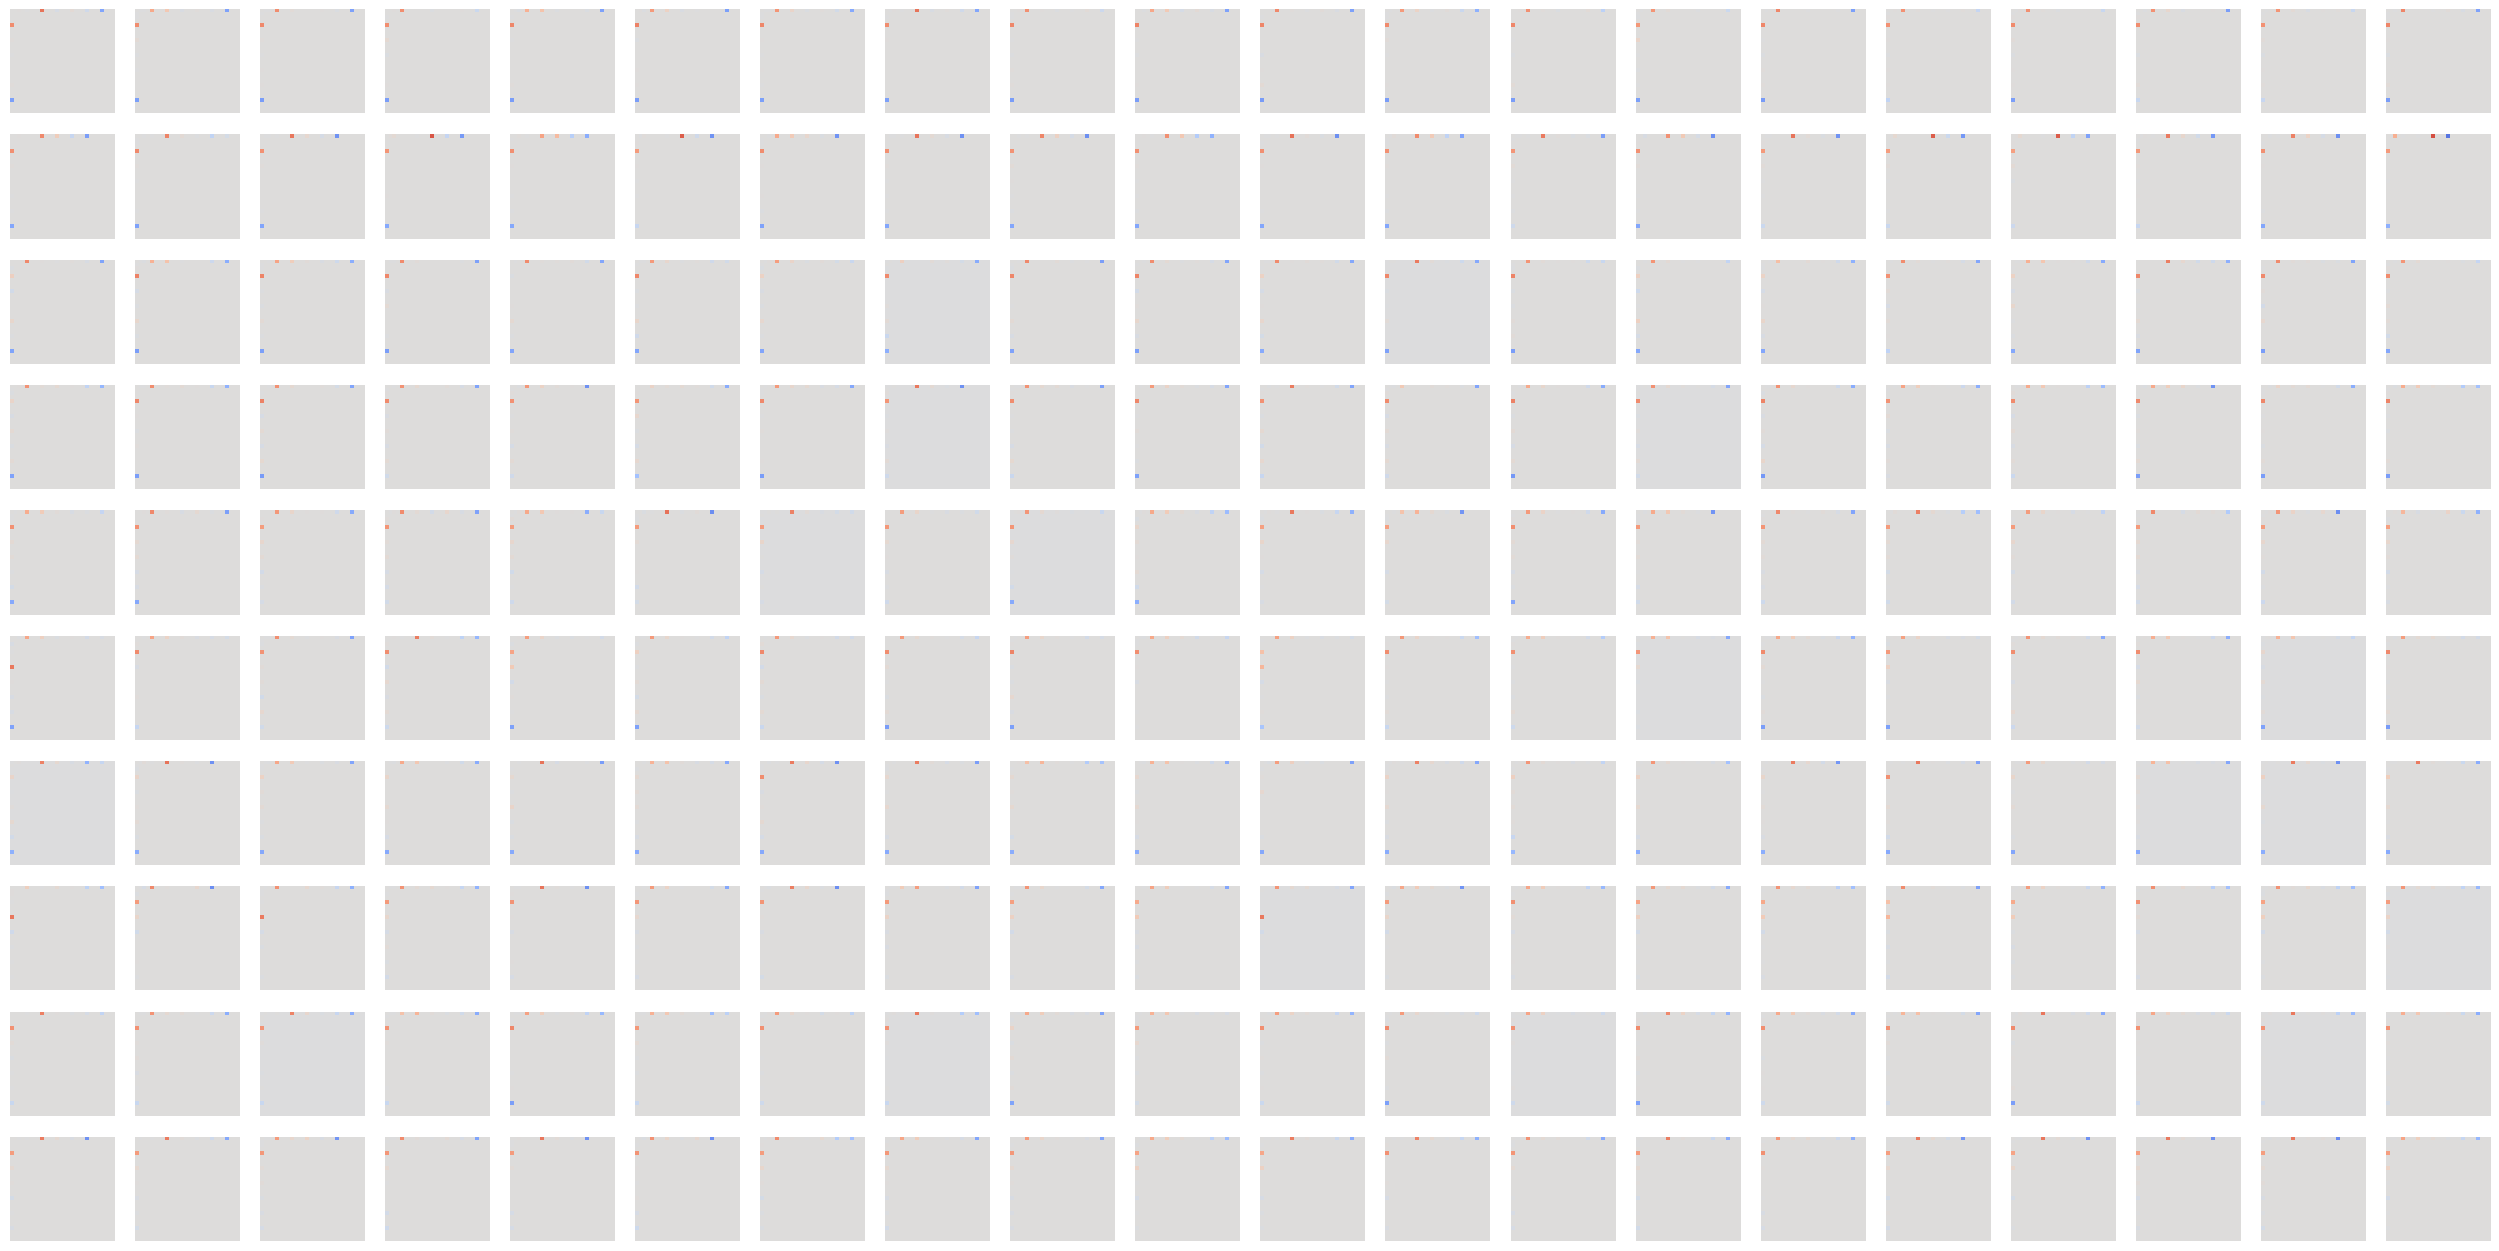

In [10]:
# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(theta_digit[digit][i].reshape((28, 28)), cmap='coolwarm', vmin=-15, vmax=15)
        plt.axis('off')  # Hide axes

plt.show()

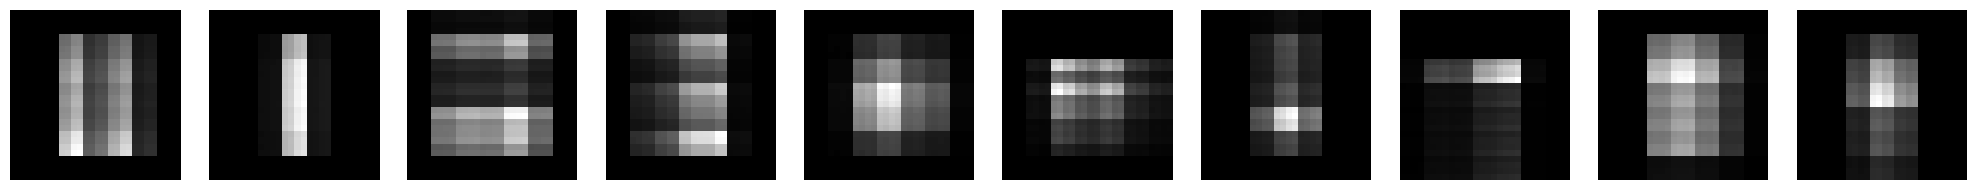

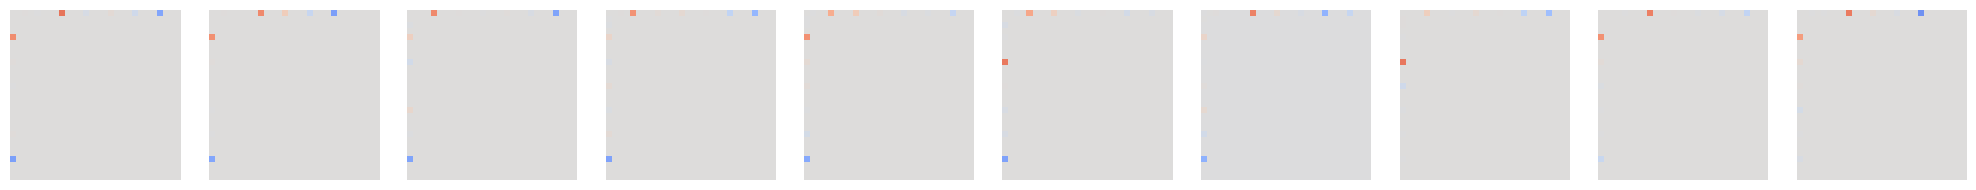

In [11]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default/LD.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(theta_digit[digit][i].reshape((28, 28)), cmap='coolwarm', vmin=-15, vmax=15)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default/LD_parameter.pdf', format='pdf')

plt.show()

#### Fitting on Projected Points

In [12]:
sampled_theta_digit = []

for digit in range(10):
    reduced_theta = vectorize_tensor(theta_digit[digit], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(reduced_theta)
    # Sample new data from the KDE
    sampled_reduced_theta = kde.sample(n_samples=new_sample_size_per_digit)

    sampled_theta = reconstruct_tensor(sampled_reduced_theta, (new_sample_size_per_digit, *S), B_LD)
    sampled_theta_digit.append(sampled_theta)

#### Construct Local Data Sub-Manifold

In [13]:
# Construct the constrained coordinates
# B_BP = ld.block_B([14, 14], [15, 15])
B_BP = ld.default_B(S, 1, cp.get_array_module(P[0]))
print(f"Dimension of Local Data Sub-Manifold: {D - B_BP.shape[0]}")

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_digit = []

for digit in range(10):
    eta_hat_list = []
    for i in range(P_digit[digit].shape[0]):
        xp = cp.get_array_module(P_digit[digit][i])
        P = (P_digit[digit][i] + eps) / scaleX_digit[digit][i]
        eta_hat = ld.get_eta(P, len(S), xp)
        eta_hat_list.append(eta_hat)

    eta_hat_digit.append(cp.asarray(eta_hat_list))

Dimension of Local Data Sub-Manifold: 767


#### Backward Projection

In [14]:
load = False
if load:
    # Load all intermediate results from disk
    results_BP = np.load('results_BP.npz')
    sampled_P_BP_digit = results_BP['sampled_P_BP_digit']
    sampled_theta_BP_digit = results_BP['sampled_theta_BP_digit']
    sampled_X_BP_digit = results_BP['sampled_X_BP_digit']
else:
    # Use a custom temporary directory
    import tempfile
    temp_dir = tempfile.mkdtemp(dir='/tmp')


    def BP_helper(i, digit):
        N = ld.kNN(sampled_theta_digit[digit][i], theta_digit[digit], k=k)
        avg_scale = np.mean(scaleX_digit[digit][N])
        avg_eta_hat = np.mean(eta_hat_digit[digit][N], axis=0)
        _, _, P, theta = ld.BP(sampled_theta_digit[digit][i], [(P_digit[digit][j] + eps) / scaleX_digit[digit][j] for j in N], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
        X_recons_ = (P).astype(np.int32).reshape(-1)
        return (P, theta, X_recons_)

    results = Parallel(n_jobs=10, temp_folder=temp_dir)(delayed(BP_helper)(i, digit) for i in range(new_sample_size_per_digit) for digit in range(10))

    sampled_P_BP_digit = []
    sampled_theta_BP_digit = []
    sampled_X_BP_digit = []

    for digit in range(10):
        sampled_P_BP = []
        sampled_theta_BP = []
        sampled_X_BP = []
        for i in range(new_sample_size_per_digit):
            result = results[i*10 + digit]

            sampled_P_BP.append(result[0])
            sampled_theta_BP.append(result[1])
            sampled_X_BP.append(result[2])

        sampled_P_BP_digit.append(np.array(sampled_P_BP))
        sampled_theta_BP_digit.append(np.array(sampled_theta_BP))
        sampled_X_BP_digit.append(np.array(sampled_X_BP))

    np.savez('results_BP.npz', sampled_P_BP_digit=sampled_P_BP_digit, sampled_theta_BP_digit=sampled_theta_BP_digit, sampled_X_BP_digit=sampled_X_BP_digit)

PicklingError: Could not pickle the task to send it to the workers.

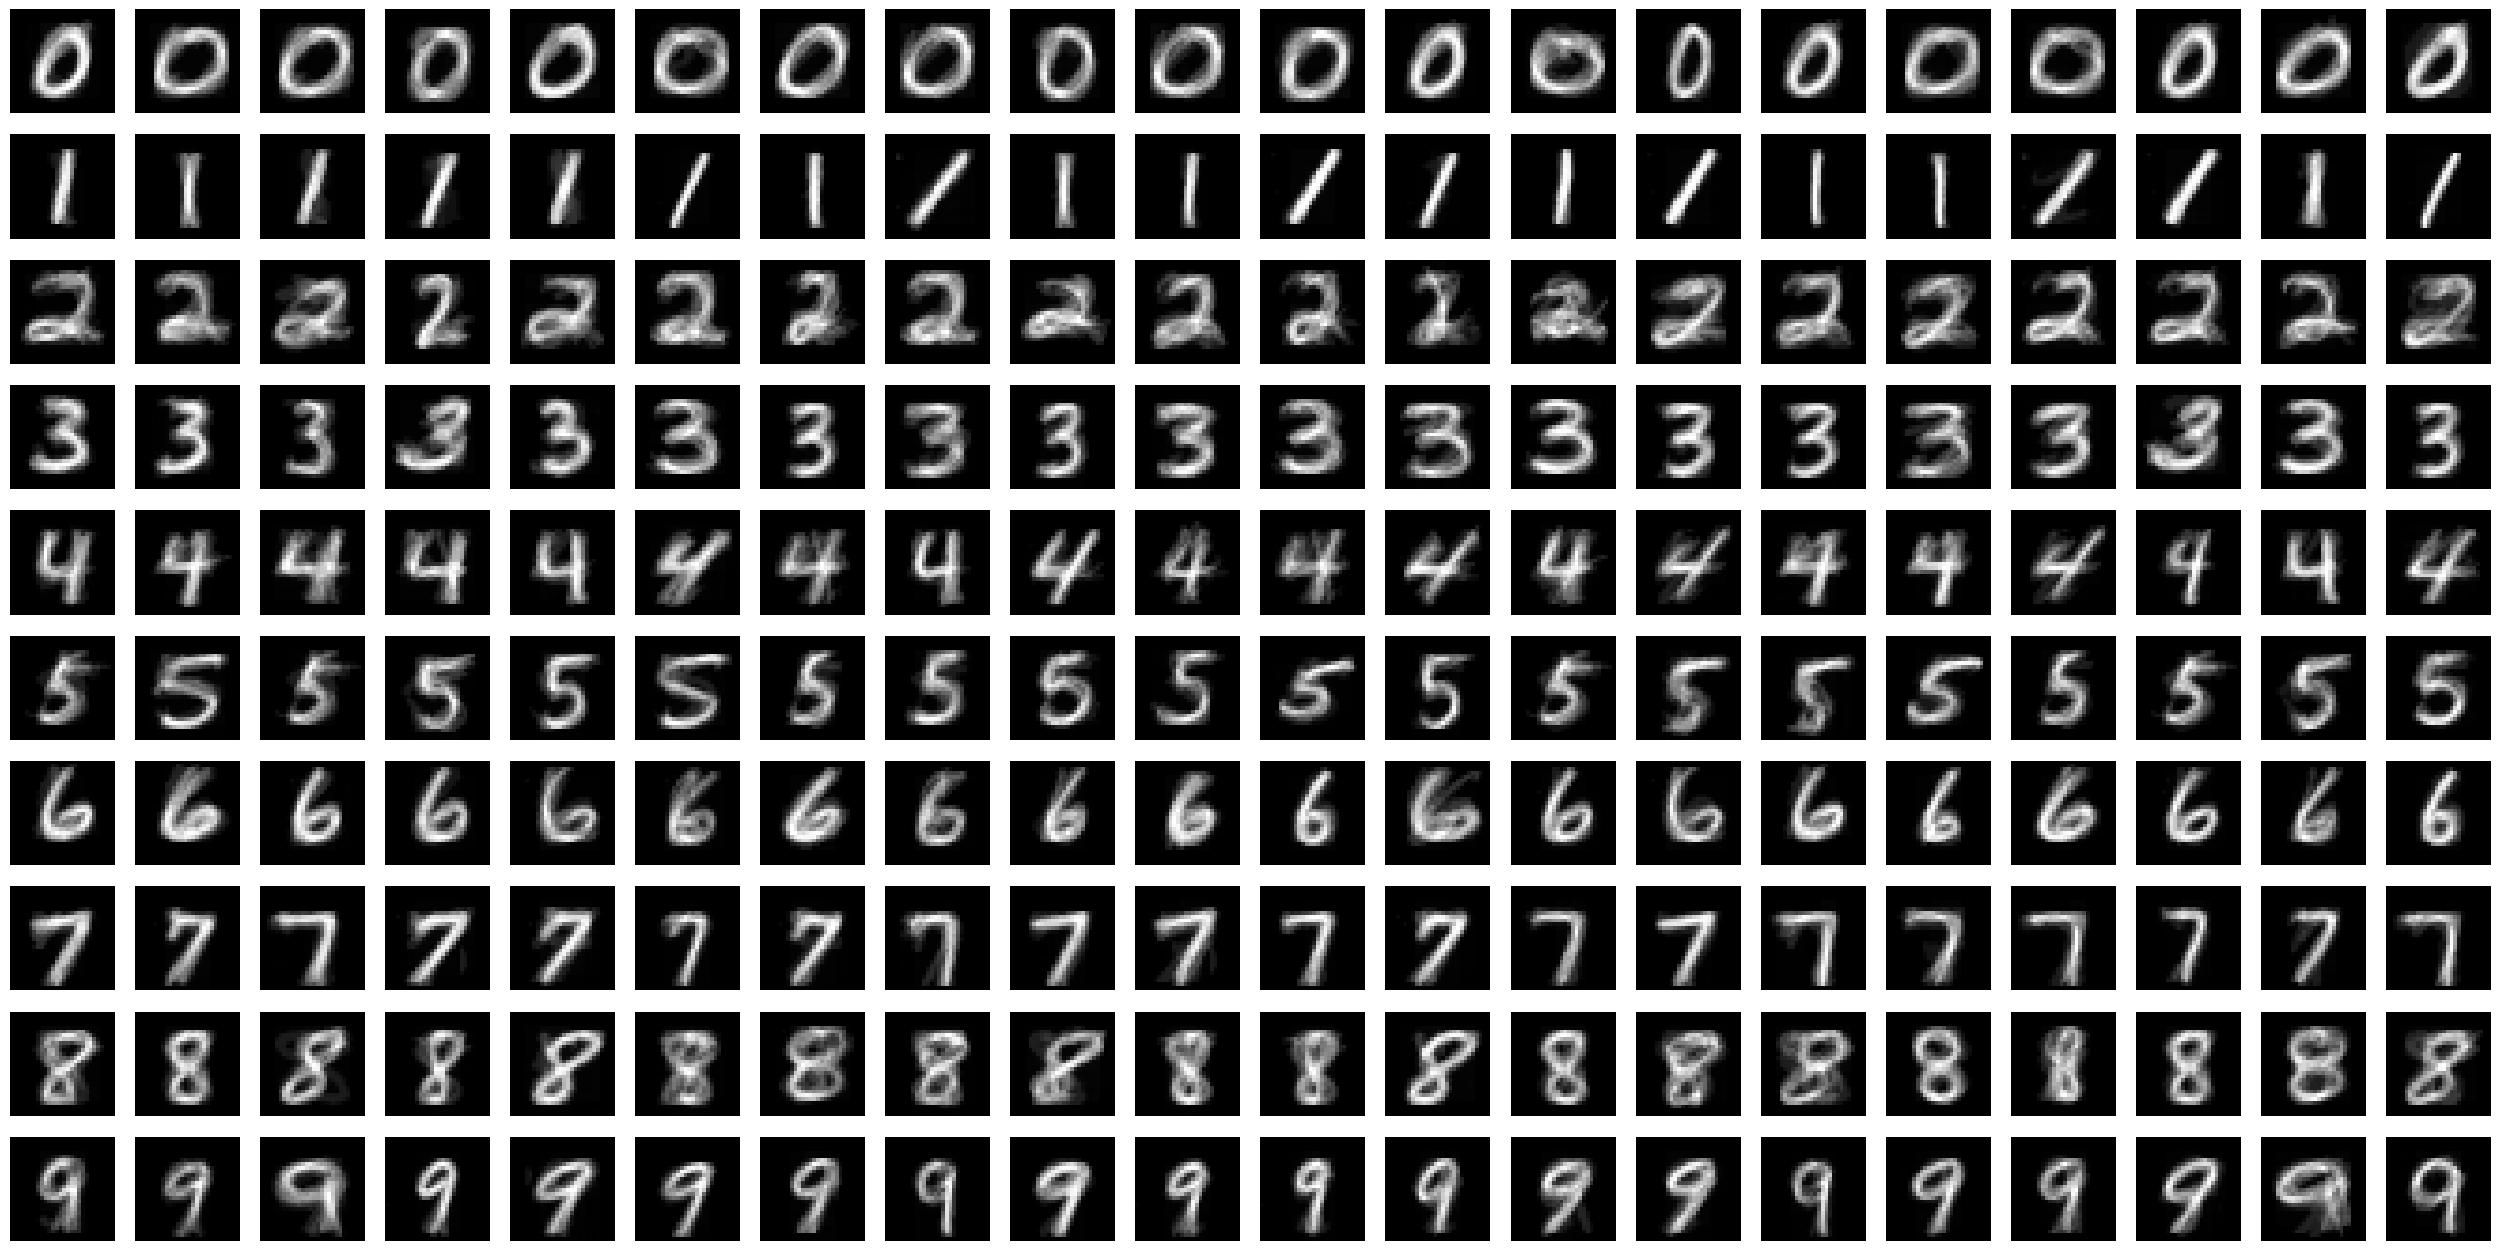

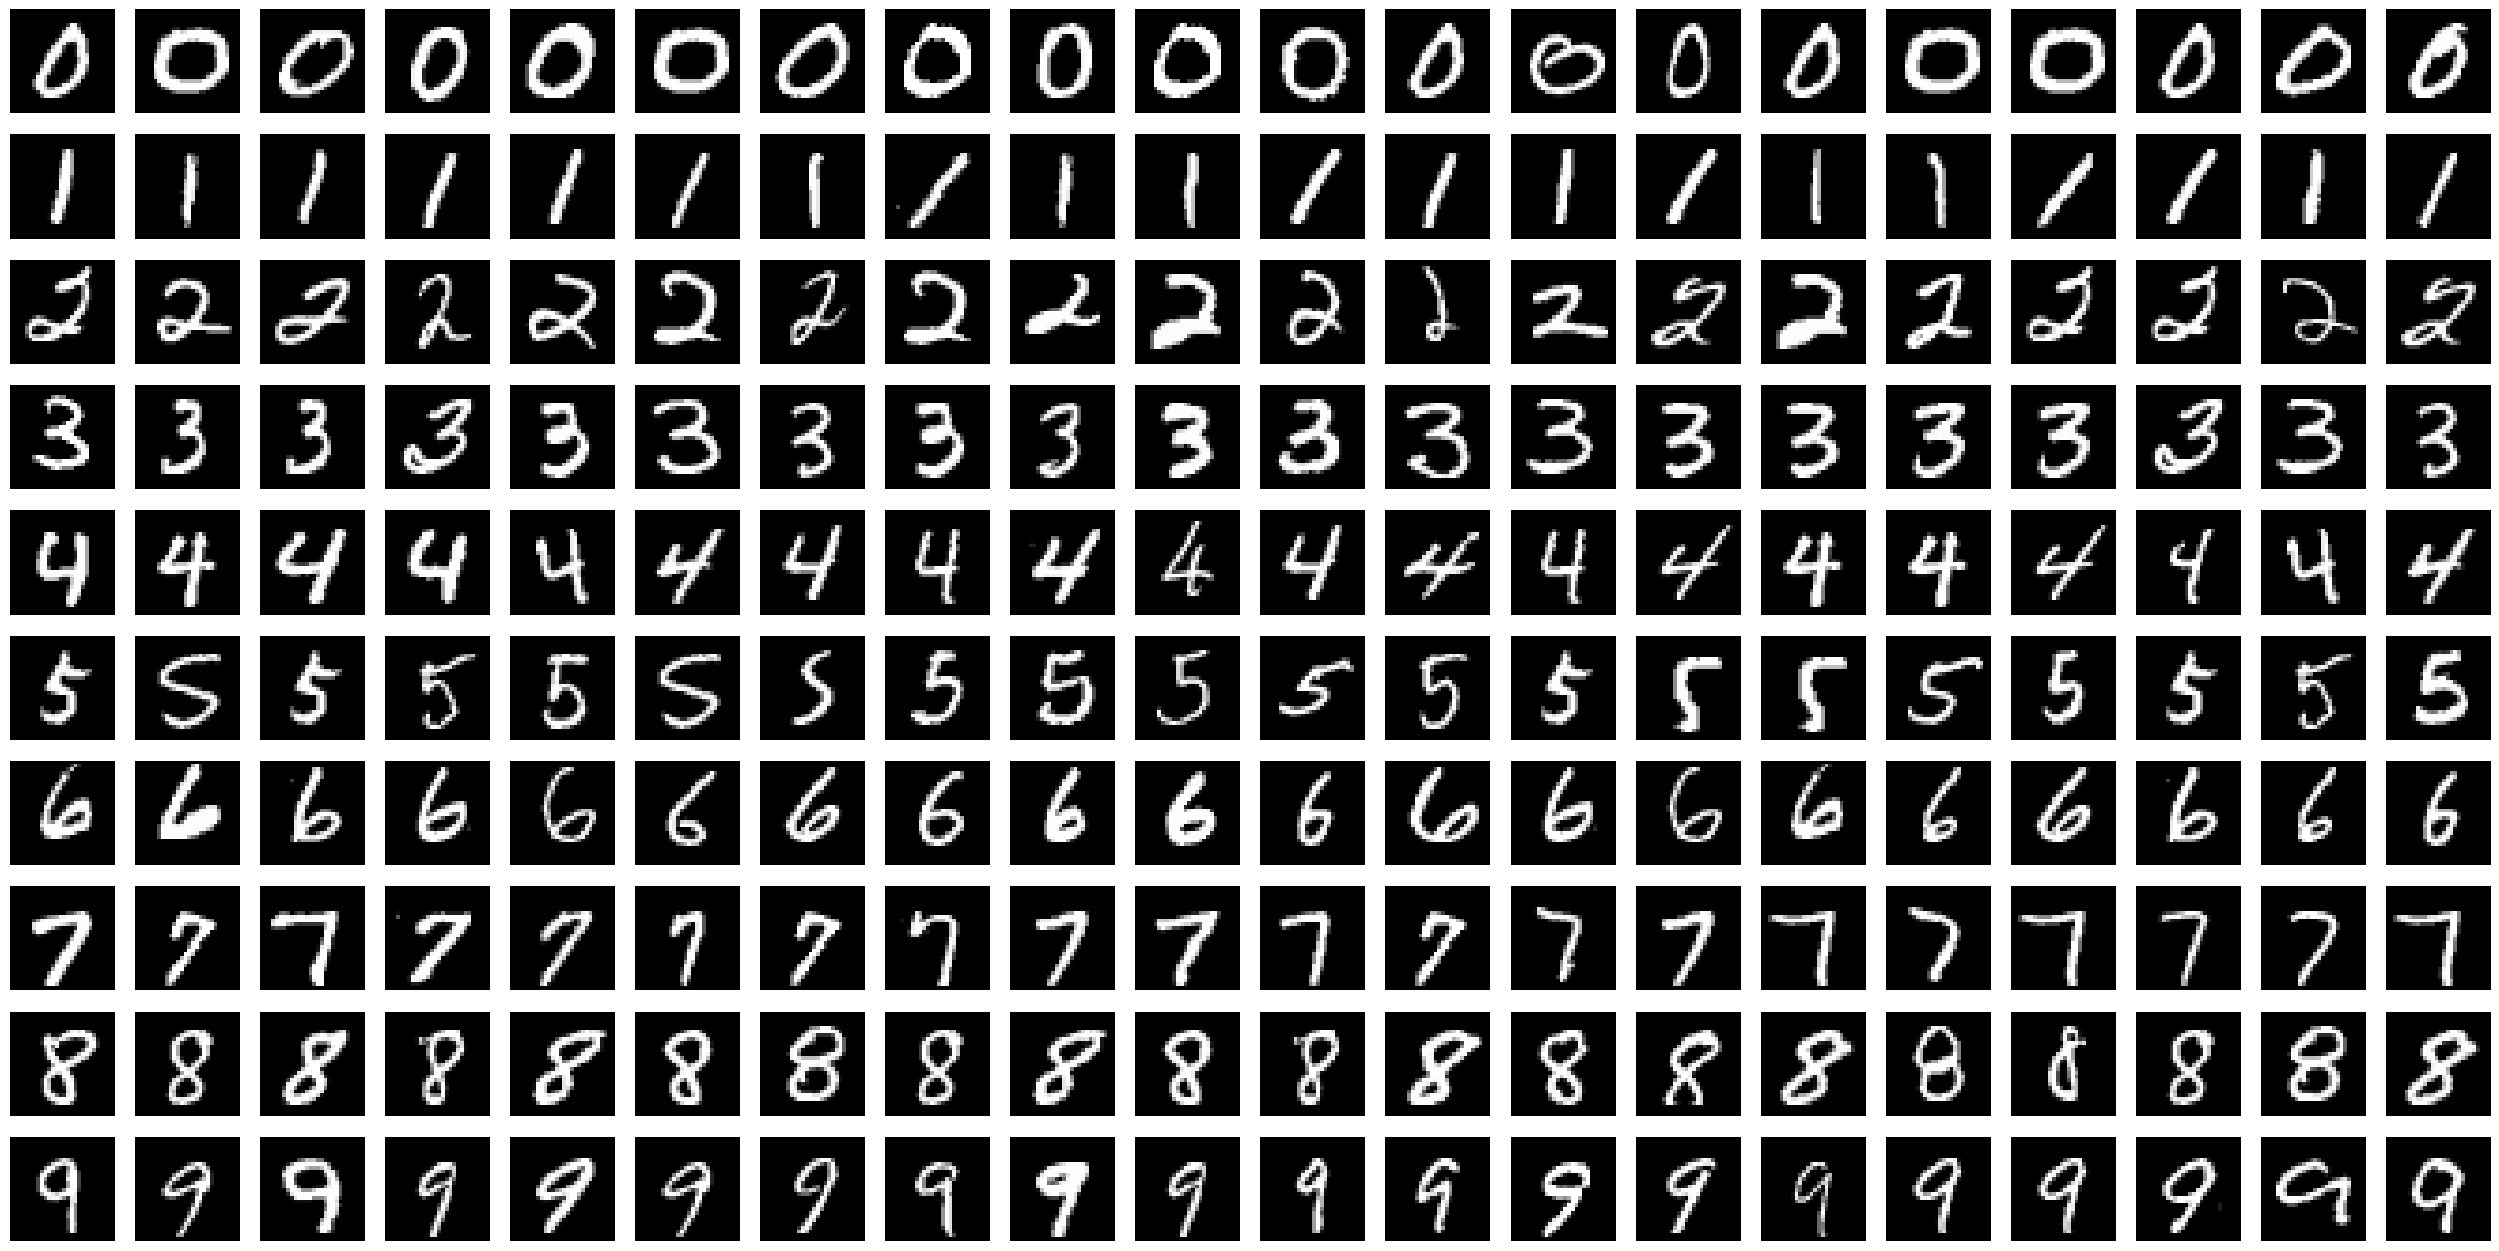

In [ ]:
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_BP_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_X_BP_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

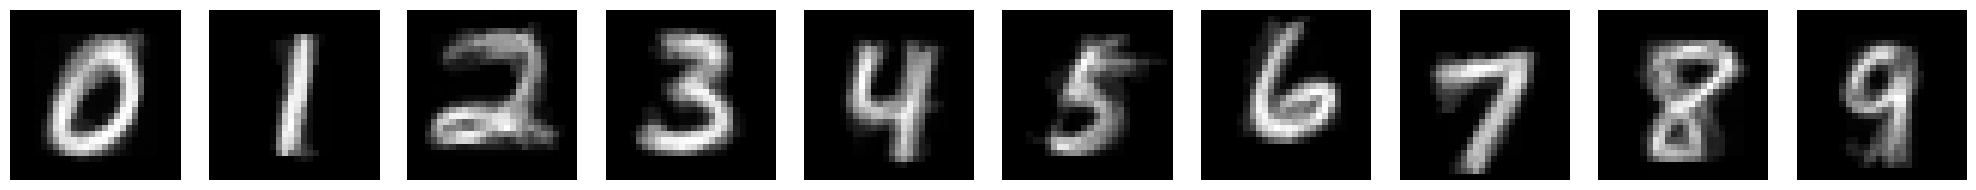

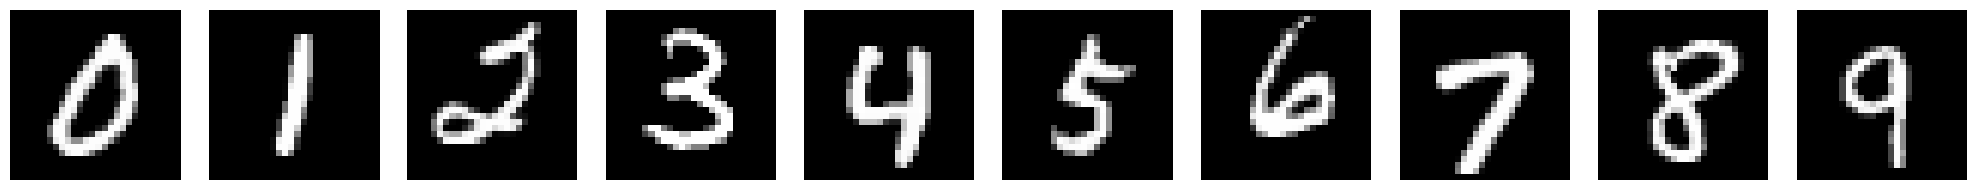

In [ ]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_BP_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default/BP.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_X_BP_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default/BP_compare.pdf', format='pdf')

plt.show()

## Data Augmentation with Autoencoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_channels=1, feature_maps=[12, 24, 48]):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, feature_maps[0], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(feature_maps[0], feature_maps[1], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(feature_maps[1], feature_maps[2], kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)


class Decoder(nn.Module):
    def __init__(self, output_channels=1, feature_maps=[48, 24, 12]):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(feature_maps[0], feature_maps[1], kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps[1], feature_maps[2], kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps[2], output_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

100%|██████████| 100/100 [28:40<00:00, 17.21s/it]


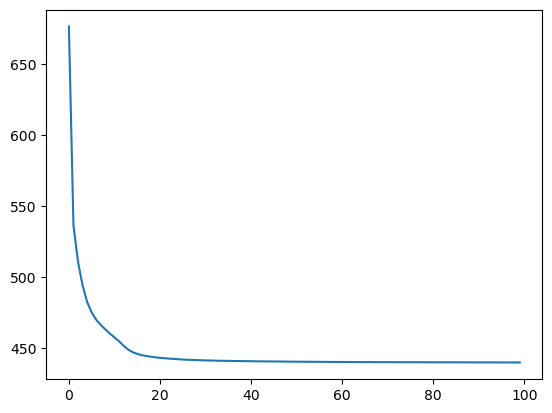

In [8]:
train_loader_original = DataLoader(dataset=datasets.MNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.1307], std=[0.3081]),])), batch_size=64, shuffle=True)

enc = Encoder(input_channels=1, feature_maps=[1, 12, 48]).to(device)  # Update for single-channel grayscale
dec = Decoder(output_channels=1, feature_maps=[48, 12, 1]).to(device)
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters(), lr=1e-3)
optimizer_dec = torch.optim.Adam(dec.parameters(), lr=1e-3)

train_loss = []
num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = 0
    for imgs, _ in train_loader_original:
        imgs = imgs.to(device)

        # Forward pass
        latents = enc(imgs)  # Encode to latent space
        output = dec(latents)  # Reconstruct image

        # Compute loss
        loss = loss_fn(output, imgs)
        train_epoch_loss += loss.item()

        # Backpropagation
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
    train_loss.append(train_epoch_loss)

plt.plot(train_loss)

In [ ]:
representation = None
AE_imgs = None
all_labels = []

with torch.no_grad():
    for (imgs , labels) in train_loader_original:
        imgs = imgs.to(device)

        all_labels.extend(list(labels.numpy()))
        latents = enc(imgs)
        if representation is None:
            representation = latents.cpu()
        else:
            representation = torch.vstack([representation , latents.cpu()])

        if AE_imgs is None:
            AE_imgs = imgs.detach().cpu().numpy()
        else:
            AE_imgs = np.vstack([AE_imgs , imgs.detach().cpu().numpy()])

AE_digit = []
for digit in range(10):
    AE_digit.append(AE_imgs[torch.tensor(all_labels) == digit])

all_labels = np.array(all_labels)
representation = representation.numpy()

In [ ]:
representation_flatten = representation.reshape(60000, -1)
sampled_X_AE_digit = []

for digit in range(10):
    sampled_X_AE_list = []
    rep = representation_flatten[np.argwhere(all_labels == digit)].squeeze()

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_AE).fit(rep)

    # Sample new data from the KDE
    sampled_rep = kde.sample(n_samples=new_sample_size_per_digit)

    sampled_rep = sampled_rep.reshape(-1, *representation.shape[1:])
    for i in range(new_sample_size_per_digit):
        pred = dec(torch.Tensor(sampled_rep[i]).to(device)).cpu().detach().numpy()
        sampled_X_AE_list.append(pred)

    sampled_X_AE_digit.append(sampled_X_AE_list)

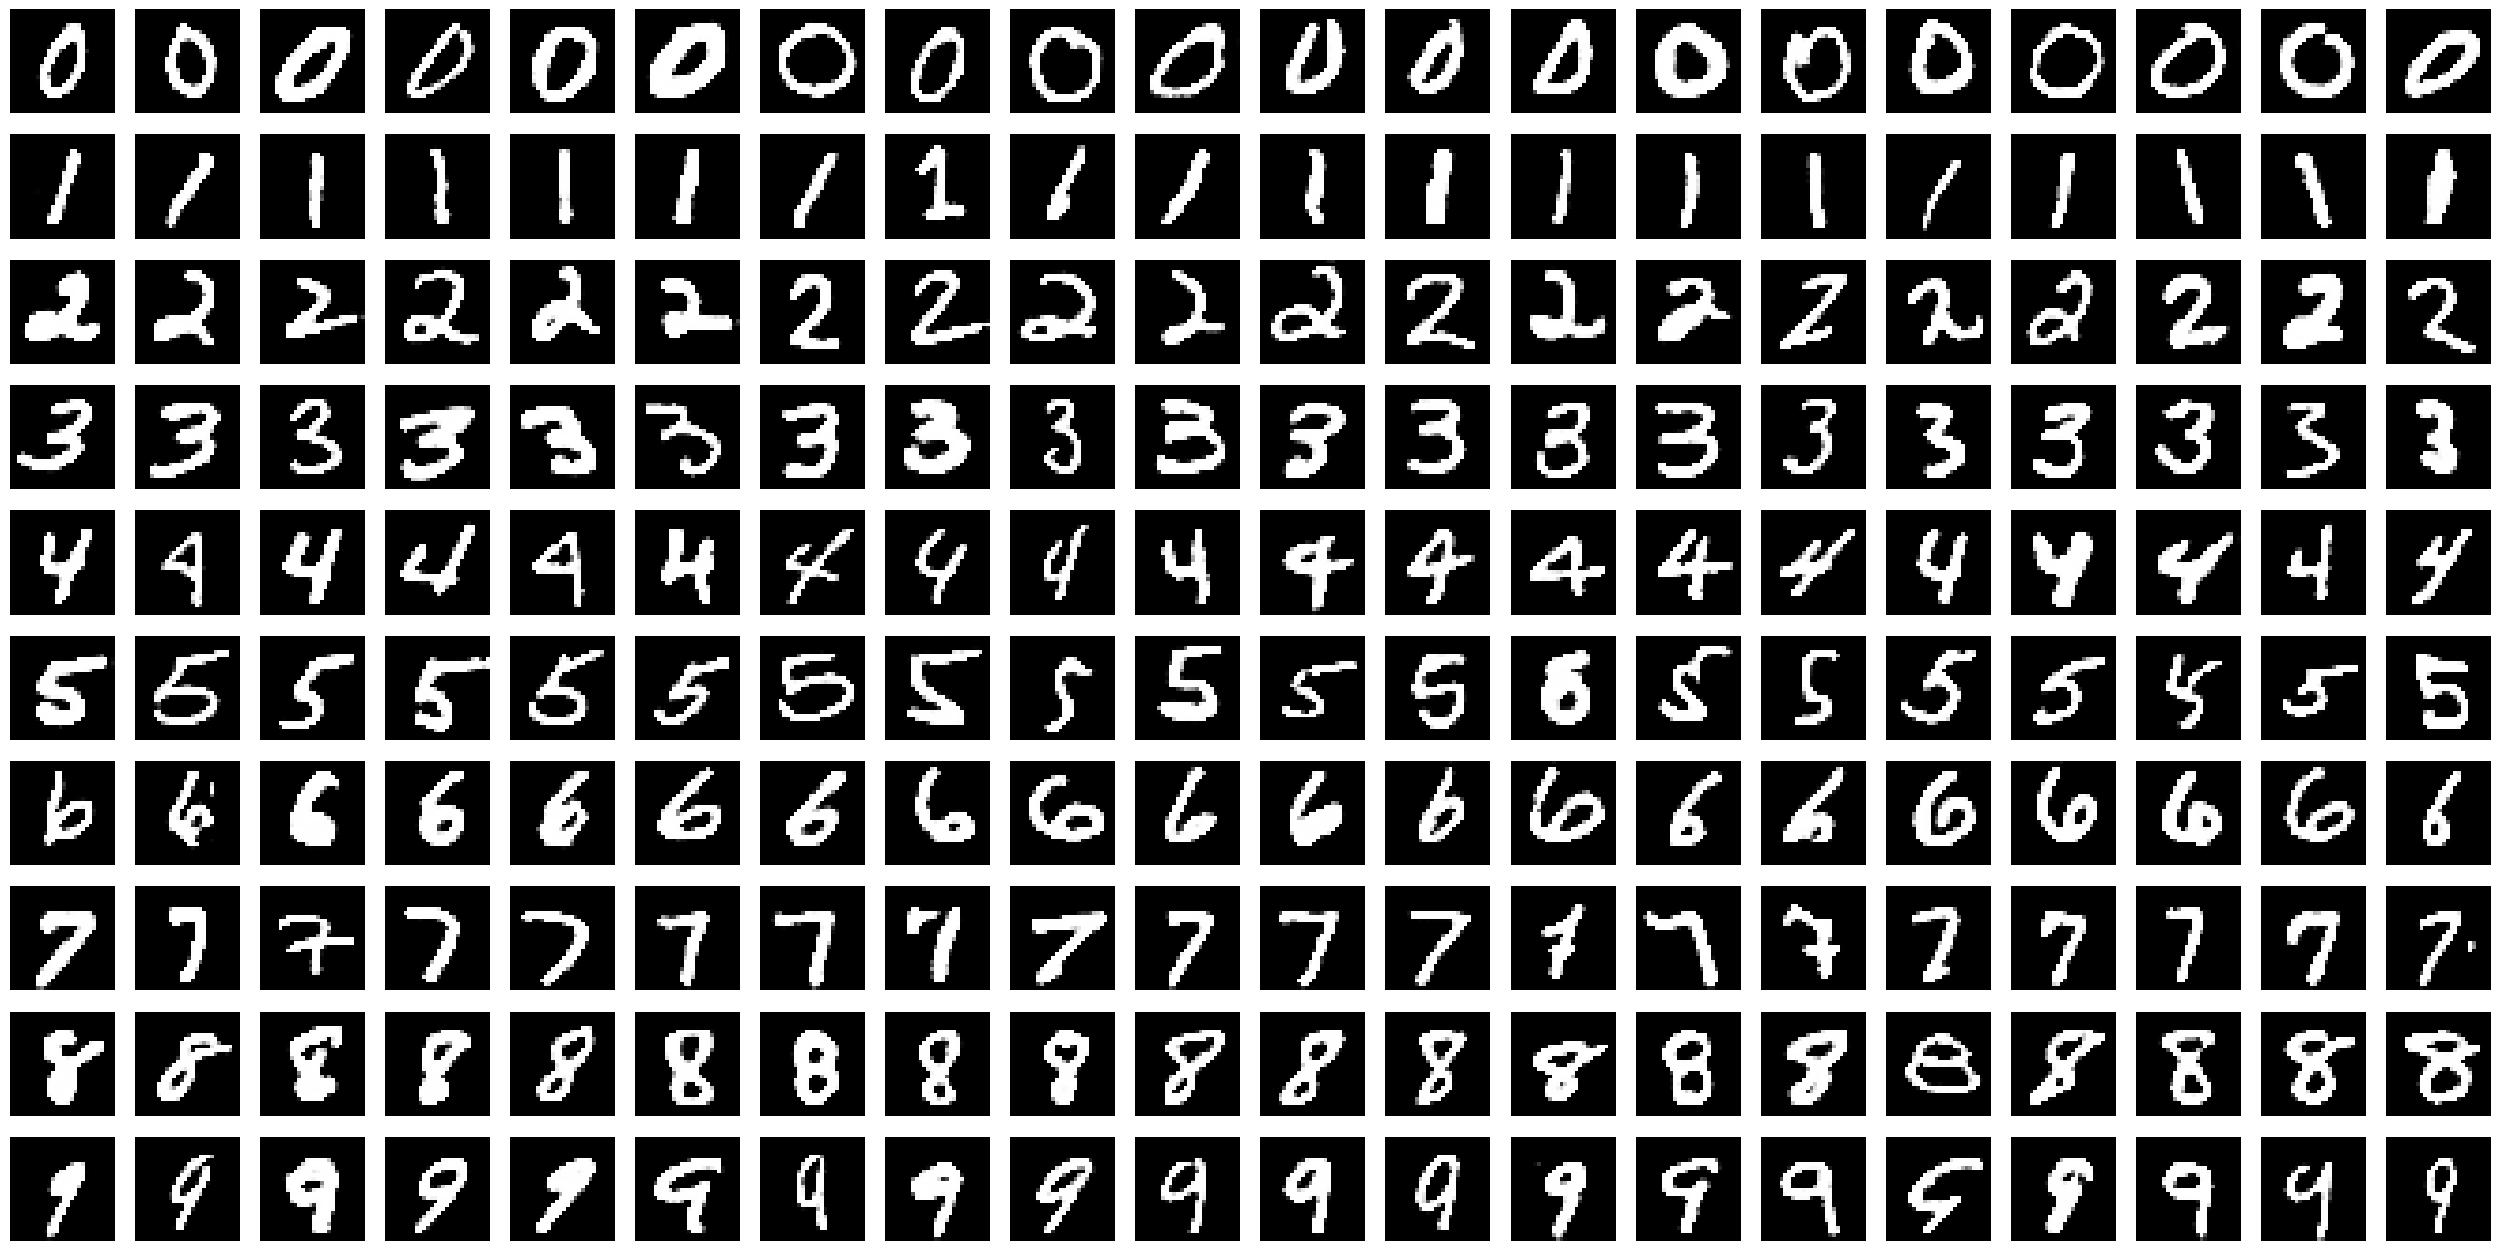

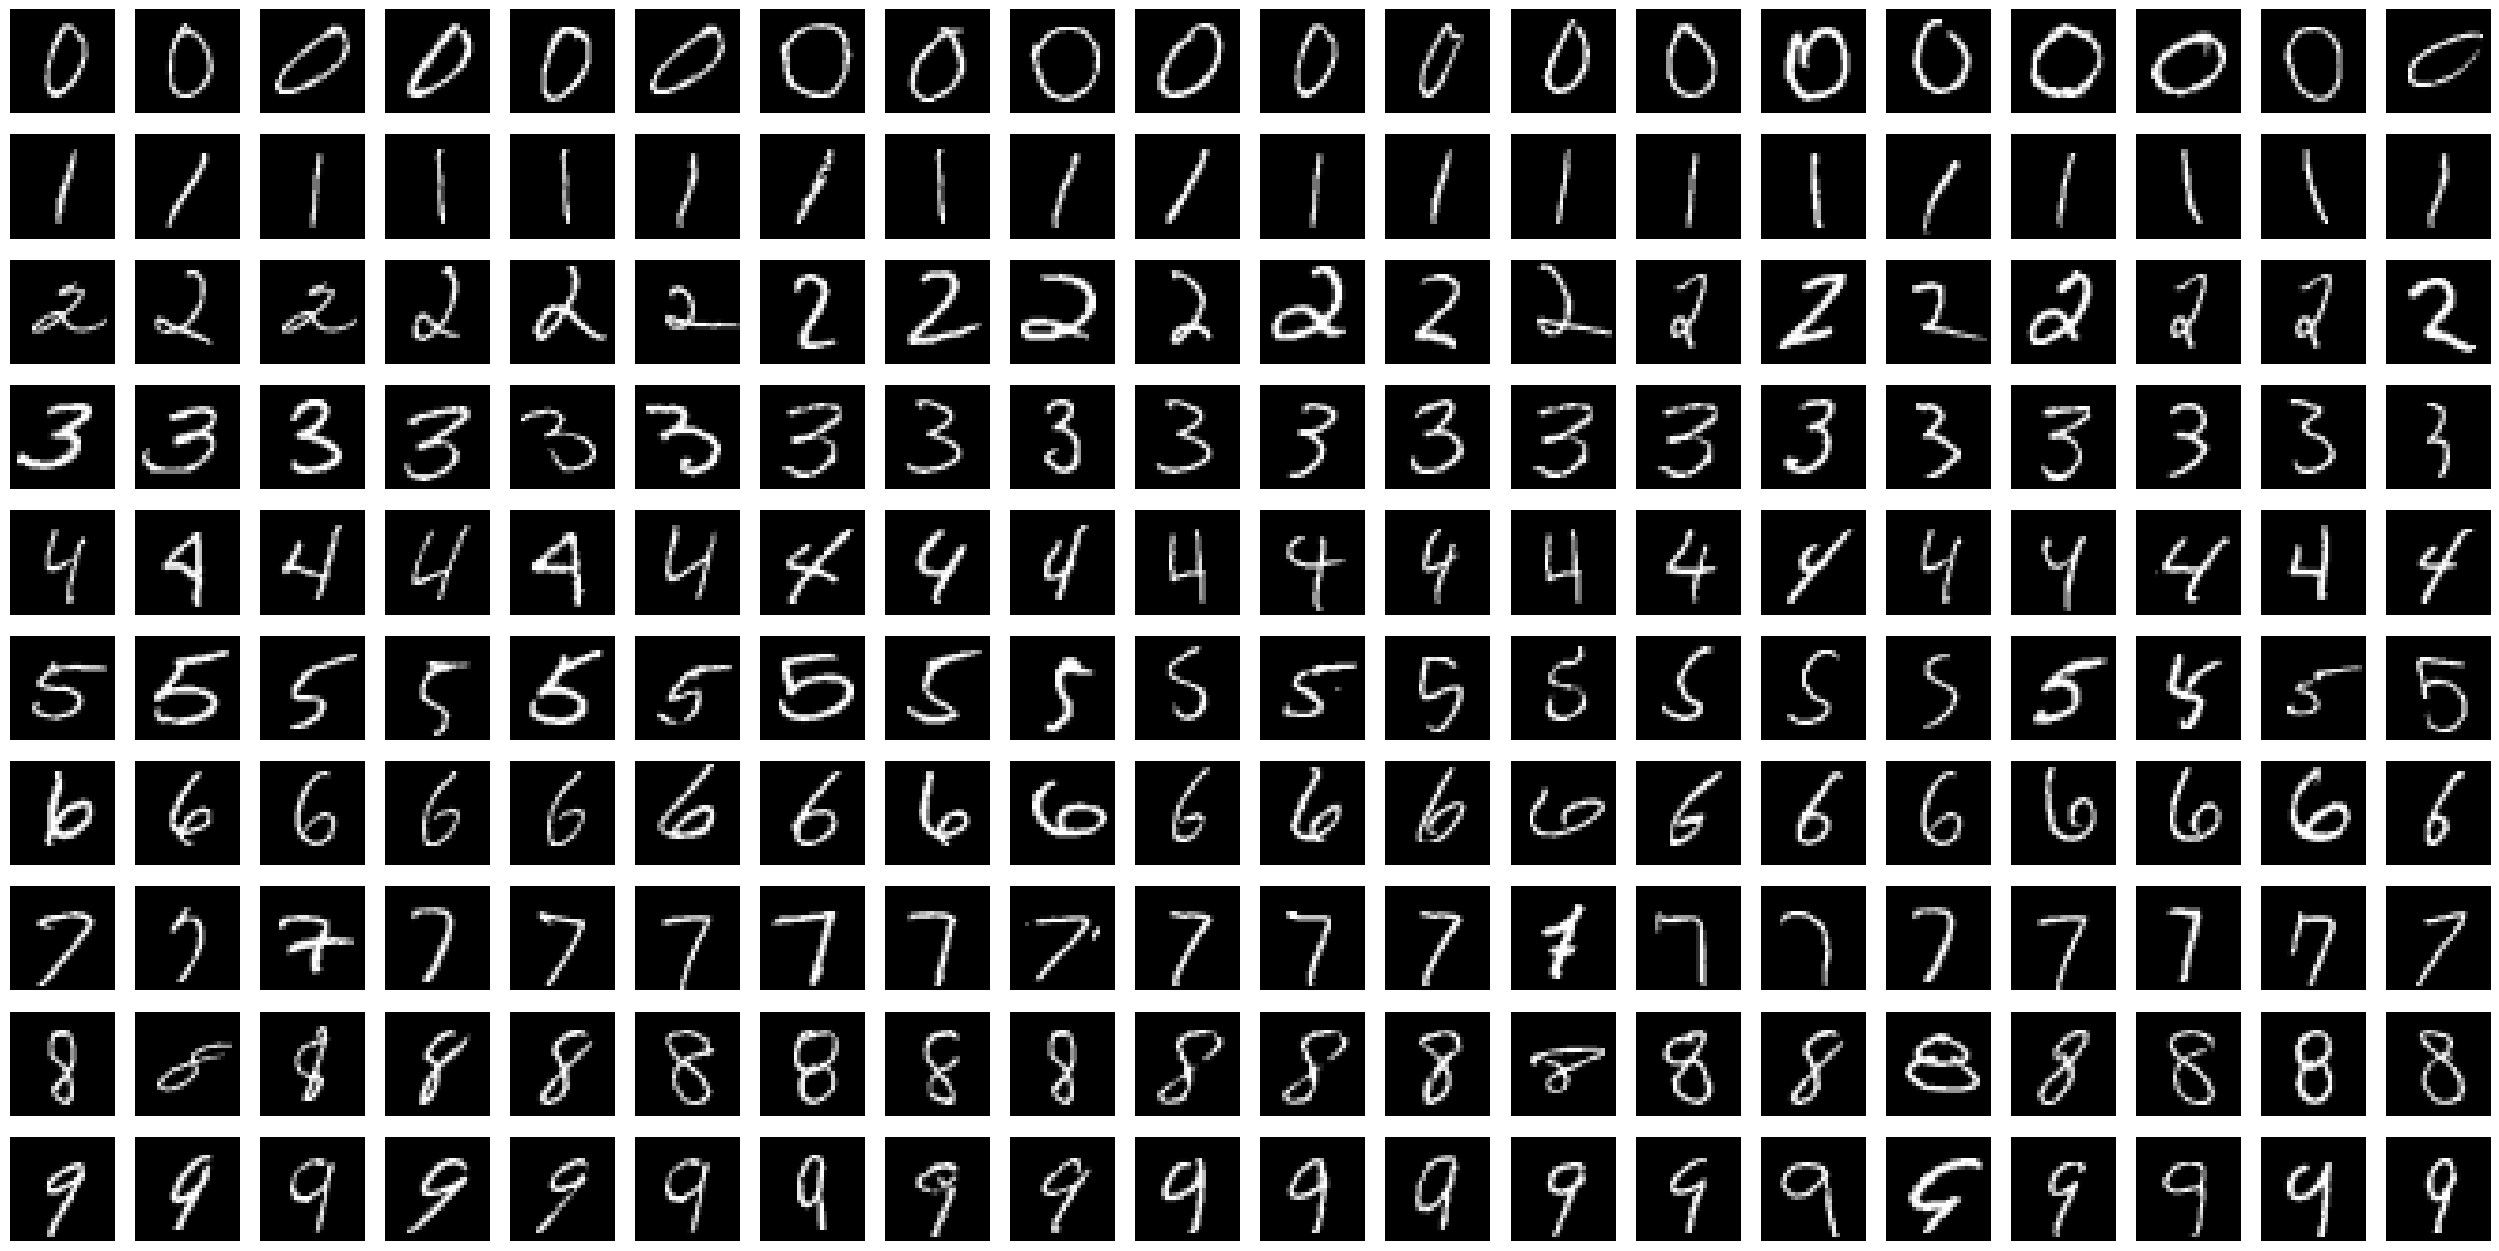

In [25]:
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_AE_digit[digit][i]).reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_X_AE_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in AE_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(AE_digit[digit][idx]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

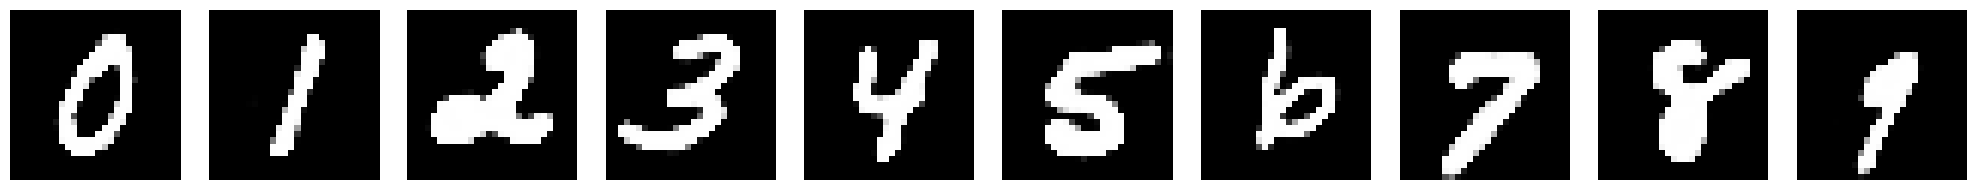

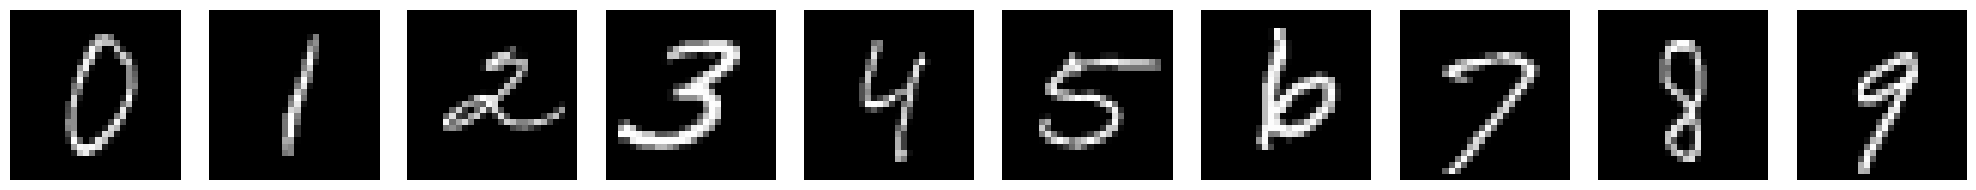

In [ ]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_AE_digit[digit][i]).reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/AE.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_X_AE_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in AE_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(AE_digit[digit][idx]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/AE_compare.pdf', format='pdf')

plt.show()

## Classification Performance

### Dataset Preparation

In [ ]:
# Helper function to create a DataLoader for augmented datasets
def prepare_augmented_dataset(original_dataset, augmented_data, augmented_labels, transform, batch_size):
    # Create dataset from augmented data
    augmented_dataset = NumpyDataset(data=augmented_data, labels=augmented_labels, transform=transform)

    # Combine with the original MNIST dataset
    combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

    # Create a DataLoader for the combined dataset
    return DataLoader(dataset=combined_dataset, batch_size=batch_size, shuffle=True)

# Main function to prepare datasets and loaders
def create_datasets_and_loaders(batch_size=64):
    # Transformations
    transform_standard = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(28, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081]),
    ])
    transform_none = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081]),
    ])
    transform_none_augmented = transforms.Compose([
        transforms.Normalize(mean=[0.1307], std=[0.3081]),
    ])

    # MNIST Datasets
    MNIST_train_standard = datasets.MNIST(root='./data', train=True, download=True, transform=transform_standard)
    MNIST_train_none = datasets.MNIST(root='./data', train=True, download=True, transform=transform_none)

    augmented_data_PNL = []
    labels_PNL = []
    augmented_data_AE = []
    labels_AE = []

    for digit in range(10):
        for img_PNL in sampled_X_BP_digit[digit]:
            augmented_data_PNL.append(renormalize_image(img_PNL).reshape((28, 28)))
            labels_PNL.append(digit)

        for img_AE in sampled_X_AE_digit[digit]:
            augmented_data_AE.append(renormalize_image(img_AE).reshape((28, 28)))
            labels_AE.append(digit)

    augmented_data_PNL = np.array(augmented_data_PNL)
    labels_PNL = np.array(labels_PNL)
    augmented_data_AE = np.array(augmented_data_AE)
    labels_AE = np.array(labels_AE)

    # Combine MNIST with augmented data
    train_loader_PNL = prepare_augmented_dataset(MNIST_train_none, augmented_data_PNL, labels_PNL, transform_none_augmented, batch_size)
    train_loader_AE = prepare_augmented_dataset(MNIST_train_none, augmented_data_AE, labels_AE, transform_none_augmented, batch_size)

    # DataLoader for MNIST only
    train_loader_standard = DataLoader(MNIST_train_standard, batch_size=batch_size, shuffle=True)
    train_loader_none = DataLoader(MNIST_train_none, batch_size=batch_size, shuffle=True)

    return {
        "standard": train_loader_standard,
        "none": train_loader_none,
        "PNL_augmented": train_loader_PNL,
        "AE_augmented": train_loader_AE,
    }

loaders = create_datasets_and_loaders(batch_size=64)

# Check each DataLoader
for name, loader in loaders.items():
    print(f"{name} loader:")
    for images, labels in loader:
        print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
        break

train_loader_standard = loaders["standard"]
train_loader_none = loaders["none"]
train_loader_PNL = loaders["PNL_augmented"]
train_loader_AE = loaders["AE_augmented"]

standard loader:
Images shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
none loader:
Images shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
LD_augmented loader:
Images shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])
AE_augmented loader:
Images shape: torch.Size([64, 1, 28, 28]), Labels shape: torch.Size([64])


### MLP Model

In [45]:
# Define Logistic Regression Model
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, self.input_size)  # Flatten the input
        x = self.activation(self.hidden_layer(x))  # Apply hidden layer + ReLU
        x = self.output_layer(x)  # Apply output layer
        return x

# Training Function
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device='cuda'):
    train_loss = []
    model.to(device)
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_epoch_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

        scheduler.step()
        train_loss.append(train_epoch_loss)

    plt.plot(train_loss)

# Testing Function
def test_model(model, test_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Bootstrapping Function
def bootstrapping(train_loader, test_dataset, num_epochs=10, learning_rate=1e-1, n_bootstrap=20, device='cuda'):
    """
    Train the Logistic Regression model on the training dataset, and evaluate it using bootstrapping on the test dataset.

    Args:
        train_loader: DataLoader for training data.
        test_dataset: Dataset object for the test data.
        num_epochs: Number of epochs for training.
        learning_rate: Learning rate for the optimizer.
        device: Device to run the training on ('cuda' or 'cpu').

    Returns:
        Prints the mean accuracy and 95% confidence interval after bootstrapping.
    """
    # Initialize the model, loss, and optimizer
    model = MLP(input_size=28*28, num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Decay LR every 30 epochs

    # Train the model
    train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, device=device)

    # Perform bootstrapping
    accuracies = []

    num_test_samples = len(test_dataset) // 2
    for i in range(n_bootstrap):
        indices = torch.randint(len(test_dataset), size=(num_test_samples,))  # Sample 500 random indices
        bootstrap_subset = Subset(test_dataset, indices)
        bootstrap_loader = DataLoader(dataset=bootstrap_subset, batch_size=num_test_samples, shuffle=False)

        accuracy = test_model(model, bootstrap_loader, device=device)
        accuracies.append(accuracy)

    # Compute statistics
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print(f"Mean accuracy: {mean_accuracy:.2f}%")
    print(f"Standard deviation: {std_accuracy:.2f}")

### Dataset Performance

In [ ]:
bootstrapping(train_loader_none, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

In [33]:
bootstrapping(train_loader_standard, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

Epoch [1/20], Loss: 0.8589
Epoch [2/20], Loss: 0.4811
Epoch [3/20], Loss: 0.4137
Epoch [4/20], Loss: 0.3812
Epoch [5/20], Loss: 0.3605
Epoch [6/20], Loss: 0.3496
Epoch [7/20], Loss: 0.3318
Epoch [8/20], Loss: 0.3305
Epoch [9/20], Loss: 0.3162
Epoch [10/20], Loss: 0.3133
Epoch [11/20], Loss: 0.3082
Epoch [12/20], Loss: 0.3053
Epoch [13/20], Loss: 0.2995
Epoch [14/20], Loss: 0.2968
Epoch [15/20], Loss: 0.2958
Epoch [16/20], Loss: 0.2916
Epoch [17/20], Loss: 0.2874
Epoch [18/20], Loss: 0.2813
Epoch [19/20], Loss: 0.2791
Epoch [20/20], Loss: 0.2791
Mean accuracy: 91.00%
95% confidence interval: (88.84%, 93.16%)


In [ ]:
bootstrapping(train_loader_PNL, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

Epoch [1/20], Loss: 0.2595
Epoch [2/20], Loss: 0.1141
Epoch [3/20], Loss: 0.0799
Epoch [4/20], Loss: 0.0607
Epoch [5/20], Loss: 0.0472
Epoch [6/20], Loss: 0.0386
Epoch [7/20], Loss: 0.0300
Epoch [8/20], Loss: 0.0249
Epoch [9/20], Loss: 0.0201
Epoch [10/20], Loss: 0.0157
Epoch [11/20], Loss: 0.0126
Epoch [12/20], Loss: 0.0102
Epoch [13/20], Loss: 0.0084
Epoch [14/20], Loss: 0.0068
Epoch [15/20], Loss: 0.0055
Epoch [16/20], Loss: 0.0047
Epoch [17/20], Loss: 0.0039
Epoch [18/20], Loss: 0.0034
Epoch [19/20], Loss: 0.0030
Epoch [20/20], Loss: 0.0027
Mean accuracy: 98.20%
95% confidence interval: (97.25%, 99.15%)


In [ ]:
bootstrapping(train_loader_AE, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

Epoch [1/20], Loss: 0.2629
Epoch [2/20], Loss: 0.1149
Epoch [3/20], Loss: 0.0795
Epoch [4/20], Loss: 0.0606
Epoch [5/20], Loss: 0.0481
Epoch [6/20], Loss: 0.0386
Epoch [7/20], Loss: 0.0314
Epoch [8/20], Loss: 0.0250
Epoch [9/20], Loss: 0.0196
Epoch [10/20], Loss: 0.0161
Epoch [11/20], Loss: 0.0131
Epoch [12/20], Loss: 0.0106
Epoch [13/20], Loss: 0.0085
Epoch [14/20], Loss: 0.0069
Epoch [15/20], Loss: 0.0057
Epoch [16/20], Loss: 0.0046
Epoch [17/20], Loss: 0.0040
Epoch [18/20], Loss: 0.0035
Epoch [19/20], Loss: 0.0030
Epoch [20/20], Loss: 0.0028
Mean accuracy: 98.33%
95% confidence interval: (97.18%, 99.48%)
